<a href="https://colab.research.google.com/github/VolodymyrKokhan/Online-store-sales-analytics-using-three-tools-SQL-Python-and-Tableau/blob/main/Portfolio_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Online store sales analytics using three tools: SQL, Python, and Tableau**


This project aims to analyze the operations of an international online company over a three-month period. Throughout the project, we will create a dataset using an **SQL query to a BigQuery database**, then perform **exploratory analysis** and **statistical research** using **Python methods**. In the end, conclusions will be drawn and a dashboard will be created using **Tableau**. The project will focus on analyzing the company's key metrics in terms of market geography, device types and user activity, traffic channels, and product categories.

---

Цей проєкт спрямований на аналіз діяльності міжнародної онлайн-компанії за 3 місяці. Протягом виконання проєкту ми сформуємо датасет за допомогою **SQL запиту до бази у BigQuery**, далі проведемо **дослідницький аналіз** та **статистичні дослідження** за допомогою методів **Python**. В кінці будуть зроблені висновки та створений дашборд за допомогою **Tableau**. Проєкт буде сконцентрований на аналізі основних метрик діяльності компанії у розрізі географії ринку, типів девайсів та активності користувачів, каналів трафіку та категорій продуктів.

[Link to the Tableau Dashboard](https://public.tableau.com/views/E-COMMERCECOMPANY/E-COMMERCECOMPANY?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link)

---
[Посилання на дашборд в Tableau](https://public.tableau.com/views/E-COMMERCECOMPANY/E-COMMERCECOMPANY?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link)


# **Import necessary libraries**

In [ ]:
!pip install --upgrade google-cloud-bigquery
from google.colab import auth
from google.cloud import bigquery
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.3/259.3 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: google-cloud-bigquery
    Found existing installation: google-cloud-bigquery 3.37.0
    Uninstalling google-cloud-bigquery-3.37.0:
      Successfully uninstalled google-cloud-bigquery-3.37.0


# **Connecting to a database in BigQuery and creating the Dataframe**

In [ ]:
auth.authenticate_user()
client_1 = bigquery.Client(project="data-analytics-mate")

Before writing the queries, an exploratory data analysis was conducted in SQL to identify which tables and columns contain duplicate values, missing values, unique values, and atypical values that need to be replaced with more understandable ones. All sessions are unique and contain no duplicates, so every session from the database was included, and join types were selected accordingly. The SQL query was written with the purpose of both forming a dataframe and simultaneously handling all these cases.

---
Перед написанням запитів в SQL був проведений дослідницький аналіз даних для виявлення таблиць і колонок, які містять дублікати, пропущені, унікальні та нетипові значення, що потребують заміни на більш зрозумілі. Всі сесії є унікальними та не містять дублікатів, тому кожна сесія з бази даних була включена, а типи з'єднань (join) були обрані відповідно. SQL-запит був написаний з метою як формування датафрейму, так і одночасної обробки всіх цих випадків.

In [ ]:
query_1 = """
WITH
  session_all_p AS (
  SELECT
    ss.date,
    ss.ga_session_id,
    COALESCE(device, "Unknown Device") AS device,
    COALESCE(CASE
        WHEN mobile_model_name = "<Other>" THEN "Other Model Name"
        ELSE mobile_model_name
    END
      , "Unknown Model Name") AS model_name,
    COALESCE(CASE
        WHEN operating_system = "<Other>" THEN "Other Operating System"
        ELSE operating_system
    END
      , "Unknown Operating System") AS operating_system,
    COALESCE(LANGUAGE, "Unknown Language") AS browser_language,
    COALESCE(CASE
        WHEN browser = "<Other>" THEN "Other Browser"
        ELSE browser
    END
      , "Unknown Browser") AS browser,
    COALESCE(CASE
        WHEN continent = "(not set)" THEN "Unknown Continent"
        ELSE continent
    END
      , "Unknown Continent") AS continent,
    COALESCE(CASE
        WHEN country = "(not set)" THEN "Unknown Country"
        ELSE country
    END
      , "Unknown Country") AS country,
    COALESCE(CASE
        WHEN medium = "(none)" OR medium = "(data deleted)" THEN "Unknown Source"
        WHEN medium = "<Other>" THEN "Other Source"
        ELSE medium
    END
      , "Unknown Source") AS traffic_source,
    COALESCE(CASE
        WHEN channel = "Undefined" THEN "Unknown Channel"
        ELSE channel
    END
      , "Unknown Channel") AS traffic_channel,
  FROM
    `DA.session` AS ss
  LEFT JOIN
    `DA.session_params` AS sp
  ON
    ss.ga_session_id = sp.ga_session_id ),
  account_all_info AS(
  SELECT
    ass.ga_session_id,
    ass.account_id,
    is_verified,
    is_unsubscribed
  FROM
    `DA.account_session` AS ass
  LEFT JOIN
    `DA.account` AS ac
  ON
    ass.account_id = ac.id),
  product_order_info AS(
  SELECT
    ga_session_id,
    o.item_id,
    name,
    category,
    price,
    short_description
  FROM
    `DA.order` AS o
  LEFT JOIN
    `DA.product` AS p
  ON
    o.item_id = p.item_id ),
  predict_revenue AS (
  SELECT
    date,
    predict
  FROM
    `DA.revenue_predict` )
SELECT
  ss.date AS session_date,
  CAST(ss.ga_session_id AS STRING) AS session_id,
  device,
  model_name,
  operating_system,
  browser_language,
  browser,
  continent,
  country,
  traffic_source,
  traffic_channel,
  COALESCE(CAST(account_id AS STRING), "Guest") AS account_id,
  CASE
    WHEN is_verified IS NULL THEN "Guest"
    WHEN is_verified = 1 THEN "Yes"
    ELSE "No"
END
  AS is_verified,
  CASE
    WHEN is_unsubscribed IS NULL THEN "Guest"
    WHEN is_unsubscribed = 0 THEN "Yes"
    ELSE "No"
END
  AS is_subscribed,
  COALESCE(CAST(item_id AS STRING), "No orders session") AS product_id,
  COALESCE(name, "No orders session") AS product_name,
  COALESCE(category, "No orders session") AS product_category,
  price AS product_price,
  COALESCE(short_description, "No orders session") AS product_short_description,
  predict AS daily_revenue_predict,
  SUM(price) OVER(PARTITION BY ss.date) AS total_daily_revenue
FROM
  session_all_p AS ss
LEFT JOIN
  account_all_info AS ac
ON
  ss.ga_session_id = ac.ga_session_id
LEFT JOIN
  product_order_info AS po
ON
  ss.ga_session_id = po.ga_session_id
LEFT JOIN
  predict_revenue AS pr
ON
  ss.date = pr.date
ORDER BY
  session_date
"""

query_running = client_1.query(query_1)  # Executing an SQL query
results_1 = query_running.result()  # Waiting for the query to complete

company_data = results_1.to_dataframe()


**SQL Query Description:**

  * The SQL query includes separate CTEs (Common Table Expressions) for joining tables with data on sessions, accounts, products, and expected revenue.
  * The total revenue for each date is calculated using a window function.
  * Missing values are filled with a clear comment using the **COALESCE** function.
  * Values such as `"\<Other\>" `and `"(not set)" `are replaced with a more understandable comment using **CASE WHEN**.
  * The **CAST** function is used to convert data types where necessary.
  * A **LEFT JOIN** is used to include all sessions, existing accounts, and available product information (for sessions with orders).

---
**Опис SQL-запиту:**

  * SQL-запит містить окремі CTE (Common Table Expressions) для під'єднання таблиць із даними по сесіях, акаунтах, продуктах та очікуваному доходу.
  * Загальний дохід на кожну дату розрахований за допомогою віконної функції.
  * Пропущені значення заповнюються зрозумілим коментарем за допомогою функції **COALESCE**.
  * Значення типу `"\<Other\>"` та `"(not set)"` замінюються більш зрозумілим коментарем за допомогою **CASE WHEN**.
  * Для перетворення типу даних, де це потрібно, використовується функція **CAST**.
  * Використовується тип з'єднання **LEFT JOIN** для врахування всіх сесій, наявних акаунтів та наявної інформації про продукти (для сесій із замовленнями).

In [ ]:
company_data.info()
company_data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   session_date               349545 non-null  dbdate 
 1   session_id                 349545 non-null  object 
 2   device                     349545 non-null  object 
 3   model_name                 349545 non-null  object 
 4   operating_system           349545 non-null  object 
 5   browser_language           349545 non-null  object 
 6   browser                    349545 non-null  object 
 7   continent                  349545 non-null  object 
 8   country                    349545 non-null  object 
 9   traffic_source             349545 non-null  object 
 10  traffic_channel            349545 non-null  object 
 11  account_id                 349545 non-null  object 
 12  is_verified                349545 non-null  object 
 13  is_subscribed              34

,session_date,session_id,device,model_name,operating_system,browser_language,browser,continent,country,traffic_source,...,account_id,is_verified,is_subscribed,product_id,product_name,product_category,product_price,product_short_description,daily_revenue_predict,total_daily_revenue
0,2020-11-01,5760483956,desktop,Safari,Macintosh,zh,Chrome,Americas,United States,Other Source,...,Guest,Guest,Guest,99902661,VITTSJÖ,Bookcases & shelving units,609.0,"Shelving unit with laptop table, 202x36x175 cm",351952.02,244292.5
1,2020-11-01,7115337200,desktop,Chrome,Web,en-us,Chrome,Europe,United Kingdom,organic,...,Guest,Guest,Guest,99902661,VITTSJÖ,Bookcases & shelving units,609.0,"Shelving unit with laptop table, 202x36x175 cm",351952.02,244292.5
2,2020-11-01,3978035233,mobile,Other Model Name,Web,zh,Chrome,Europe,Norway,Unknown Source,...,Guest,Guest,Guest,20382932,RÅSKOG,Tables & desks,189.0,"Trolley, 35x45x78 cm",351952.02,244292.5
3,2020-11-01,9648986282,mobile,Other Model Name,Android,es-es,Chrome,Africa,Nigeria,Unknown Source,...,Guest,Guest,Guest,99902661,VITTSJÖ,Bookcases & shelving units,609.0,"Shelving unit with laptop table, 202x36x175 cm",351952.02,244292.5
4,2020-11-01,4393441533,desktop,Chrome,Windows,en-us,Chrome,Asia,China,Unknown Source,...,Guest,Guest,Guest,99902661,VITTSJÖ,Bookcases & shelving units,609.0,"Shelving unit with laptop table, 202x36x175 cm",351952.02,244292.5
5,2020-11-01,967742695,desktop,Safari,Web,en-us,Safari,Americas,United States,Unknown Source,...,Guest,Guest,Guest,99902661,VITTSJÖ,Bookcases & shelving units,609.0,"Shelving unit with laptop table, 202x36x175 cm",351952.02,244292.5
6,2020-11-01,1115082532,desktop,Safari,Macintosh,Unknown Language,Chrome,Europe,Germany,referral,...,Guest,Guest,Guest,99285117,GALANT,Cabinets & cupboards,2270.0,"Storage combination with drawers, 80x160 cm",351952.02,244292.5
7,2020-11-01,6586349543,desktop,Safari,Web,en-us,Chrome,Americas,Unknown Country,referral,...,Guest,Guest,Guest,99902661,VITTSJÖ,Bookcases & shelving units,609.0,"Shelving unit with laptop table, 202x36x175 cm",351952.02,244292.5
8,2020-11-01,5041302343,desktop,Chrome,Web,en-us,Chrome,Americas,Ecuador,organic,...,Guest,Guest,Guest,99902661,VITTSJÖ,Bookcases & shelving units,609.0,"Shelving unit with laptop table, 202x36x175 cm",351952.02,244292.5
9,2020-11-01,1129172264,mobile,Other Model Name,Android,en-us,Chrome,Americas,United States,Unknown Source,...,Guest,Guest,Guest,99902661,VITTSJÖ,Bookcases & shelving units,609.0,"Shelving unit with laptop table, 202x36x175 cm",351952.02,244292.5


All ID columns (for sessions, products, and accounts) were converted to the string data type, as no future calculations will be performed on them. This also allows us to fill null values with a more descriptive comment. For numerical columns (price? total_daily_revenue and expected revenue), null values were not filled. This will allow for future calculations without having to handle 0. Therefore, using the `info()` function, we see missing values in these columns, but none in any other column.

---

Всі колонки з ідентифікаторами (для сесій, продуктів та акаунтів) були перетворені на рядковий тип даних (string), оскільки над ними не проводитимуться подальші обчислення. Це також дозволяє заповнити нульові значення більш описовим коментарем. Для числових колонок (price, total_daily_revenue та expected revenue) нульові значення не заповнювалися. Це дозволить проводити майбутні розрахунки без необхідності обробляти 0. Тому, використовуючи функцію `info()`, ми бачимо відсутні значення у цих колонках, але не в жодній іншій.

Let's also create an additional column with the day of the week to analyze seasonal dynamics by day and convert date column to pandas datetime

---
Також створимо додаткову колонку з днем тижня для аналізу сезонної динаміки за днями та перетворимо колонку з датами на формат pandas datetime.

In [ ]:
company_data["session_date"] = pd.to_datetime(company_data["session_date"])
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_data = pd.Categorical(company_data["session_date"].dt.day_name(), categories=weekday_order, ordered=True)
company_data.insert(loc = 1, column = "weekday", value = weekday_data)
company_data.head(5)

,session_date,weekday,session_id,device,model_name,operating_system,browser_language,browser,continent,country,...,account_id,is_verified,is_subscribed,product_id,product_name,product_category,product_price,product_short_description,daily_revenue_predict,total_daily_revenue
0,2020-11-01,Sunday,5760483956,desktop,Safari,Macintosh,zh,Chrome,Americas,United States,...,Guest,Guest,Guest,99902661,VITTSJÖ,Bookcases & shelving units,609.0,"Shelving unit with laptop table, 202x36x175 cm",351952.02,244292.5
1,2020-11-01,Sunday,7115337200,desktop,Chrome,Web,en-us,Chrome,Europe,United Kingdom,...,Guest,Guest,Guest,99902661,VITTSJÖ,Bookcases & shelving units,609.0,"Shelving unit with laptop table, 202x36x175 cm",351952.02,244292.5
2,2020-11-01,Sunday,3978035233,mobile,Other Model Name,Web,zh,Chrome,Europe,Norway,...,Guest,Guest,Guest,20382932,RÅSKOG,Tables & desks,189.0,"Trolley, 35x45x78 cm",351952.02,244292.5
3,2020-11-01,Sunday,9648986282,mobile,Other Model Name,Android,es-es,Chrome,Africa,Nigeria,...,Guest,Guest,Guest,99902661,VITTSJÖ,Bookcases & shelving units,609.0,"Shelving unit with laptop table, 202x36x175 cm",351952.02,244292.5
4,2020-11-01,Sunday,4393441533,desktop,Chrome,Windows,en-us,Chrome,Asia,China,...,Guest,Guest,Guest,99902661,VITTSJÖ,Bookcases & shelving units,609.0,"Shelving unit with laptop table, 202x36x175 cm",351952.02,244292.5


# **Dataframe description**

## **Unique values in columns**

Let's also check the columns where possible for unique values to identify any discrepancies and get a better understanding of the dataset.

---

Також перевіримо колонки на наявність унікальних значень, щоб виявити будь-які невідповідності та краще зрозуміти датасет.

In [ ]:
unigue_devices = company_data["device"].unique()
unigue_model_names = company_data["model_name"].unique()
unigue_operating_systems = company_data["operating_system"].unique()
unigue_browser_languages = company_data["browser_language"].unique()
unigue_browsers = company_data["browser"].unique()
unigue_continents = company_data["continent"].unique()
unigue_countries = company_data["country"].unique()
unigue_traffic_sources = company_data["traffic_source"].unique()
unigue_traffic_channels = company_data["traffic_channel"].unique()
unigue_is_verified = company_data["is_verified"].unique()
unigue_is_subscribed = company_data["is_subscribed"].unique()
unigue_product_categories = company_data["product_category"].unique()
unigue_weekdays = company_data["weekday"].unique()

print(f"unigue_devices: {unigue_devices}\n")
print(f"unigue_model_names: {unigue_model_names}\n")
print(f"unigue_operating_systems: {unigue_operating_systems}\n")
print(f"unigue_browser_languages: {unigue_browser_languages}\n")
print(f"unigue_browsers: {unigue_browsers}\n")
print(f"unigue_continents: {unigue_continents}\n")
print(f"unigue_countries: {unigue_countries}\n")
print(f"unigue_traffic_sources: {unigue_traffic_sources}\n")
print(f"unigue_traffic_channels: {unigue_traffic_channels}\n")
print(f"unigue_is_verified: {unigue_is_verified}\n")
print(f"unigue_product_categories: {unigue_product_categories}\n")
print(f"unigue_weekdays: {unigue_weekdays}\n")

unigue_devices: ['desktop' 'mobile' 'tablet']

unigue_model_names: ['Safari' 'Chrome' 'Other Model Name' 'iPhone' 'Pixel 3' 'ChromeBook'
 'iPad' 'Pixel 4 XL' 'Edge' 'Firefox']

unigue_operating_systems: ['Macintosh' 'Web' 'Android' 'Windows' 'iOS' 'Other Operating System']

unigue_browser_languages: ['zh' 'en-us' 'es-es' 'Unknown Language' 'en-gb' 'en-ca' 'fr' 'ko' 'en'
 'de']

unigue_browsers: ['Chrome' 'Safari' 'Android Webview' 'Other Browser' 'Edge' 'Firefox']

unigue_continents: ['Americas' 'Europe' 'Africa' 'Asia' 'Oceania' 'Unknown Continent']

unigue_countries: ['United States' 'United Kingdom' 'Norway' 'Nigeria' 'China' 'Germany'
 'Unknown Country' 'Ecuador' 'Japan' 'Canada' 'Italy' 'Indonesia'
 'South Korea' 'Belgium' 'Pakistan' 'United Arab Emirates' 'Uruguay'
 'Israel' 'Czechia' 'India' 'Taiwan' 'Georgia' 'Portugal' 'Thailand'
 'Bangladesh' 'Turkey' 'Vietnam' 'Philippines' 'France' 'Switzerland'
 'Greece' 'Sweden' 'Malaysia' 'Slovenia' 'Argentina' 'Singapore' 'Spain'
 'Braz

As we can see, all columns contain only the desired values, as well as fallback values in the event of missing data.

---
Як ми бачимо, усі колонки містять лише бажані значення, а також більш зрозумілі коментарі у випадку відсутності даних.

## **Dataframe description**

In [ ]:
company_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   session_date               349545 non-null  datetime64[ns]
 1   weekday                    349545 non-null  category      
 2   session_id                 349545 non-null  object        
 3   device                     349545 non-null  object        
 4   model_name                 349545 non-null  object        
 5   operating_system           349545 non-null  object        
 6   browser_language           349545 non-null  object        
 7   browser                    349545 non-null  object        
 8   continent                  349545 non-null  object        
 9   country                    349545 non-null  object        
 10  traffic_source             349545 non-null  object        
 11  traffic_channel            349545 non-null  object  

In [ ]:
session_date_min = company_data["session_date"].min().date()
session_date_max = company_data["session_date"].max().date()

print(f"""Min date: {session_date_min}
Max date: {session_date_max}""")

Min date: 2020-11-01
Max date: 2021-01-31


**Dataframe Characteristics:**

* It contains 22 columns: 1 datetime type, 3 float types, 1 categorical type, and the rest are object types;
* It contains 349,545 rows (total number of sessions);
* Missing values are present only in the `product_price`, `daily_revenue_predict`, and `total_daily_revenue` columns; they were not filled to allow for further calculations;
* All other missing values in the columns have been filled with clear comments;
* The dataframe covers the period from November 1, 2020, to January 31, 2021.

---
* Датафрейм містить 22 колонки: 1 типу datetime, 3 типу float, 1 типу categorical та решта — типу object;
* Датафрейм містить 349 545 рядків (загальна кількість сесій);
* Пропущені значення наявні лише у колонках `product_price`, `daily_revenue_predict та total_daily_revenue`; їх не було заповнено, щоб забезпечити можливість подальших розрахунків;
* Усі інші пропущені значення у колонках були заповнені з чіткими коментарями;
* Датафрейм охоплює період з 1 листопада 2020 року до 31 січня 2021 року.

## **Column descriptions**

1.  **`session_date`** - date of the session
2.  **`weekday`** - day of the week
3.  **`session_id`** - unique session identifier
4.  **`device`** - user's device type
5.  **`model_name`** - user's device model name; `'Other Model Name'` - all other less popular models
6.  **`operating_system`** - user's operating system name; `'Other Operating System'` - all other less popular operating systems
7.  **`browser_language`** - user's browser language; `'Unknown Language'` - undetermined user language
8.  **`browser`** - user's browser name; `'Other Browser'` - all other less popular browsers
9.  **`continent`** - user's continent; `'Unknown Continent'` - continent is not set
10. **`country`** - user's country; `'Unknown Country'` - user's country is not set
11. **`traffic_source`** - the source from which the user arrived; `'Other Source'` - all other less popular traffic channels; `'Unknown Source'` - traffic source is not set
12. **`traffic_channel`** - the channel from which the user arrived; `'Unknown Channel'` - traffic channel is not set
13. **`account_id`** - unique user identifier; `'Guest'` - unregistered user
14. **`is_verified`** - user verification status: `'Yes'` - user has confirmed the account; `'No'` - user has not confirmed the account; `'Guest'` - unregistered user
15. **`is_subscribed`** - user subscription status: `'Yes'` - user is subscribed to the newsletter; `'No'` - user is not subscribed to the newsletter; `'Guest'` - unregistered user
16. **`product_id`** - unique product identifier (for sessions with orders); `'No orders session'` - a session with no orders
17. **`product_name`** - product name (for sessions with orders); `'No orders session'` - a session with no orders
18. **`product_category`** - product category (for sessions with orders); `'No orders session'` - a session with no orders
19. **`product_price`** - product price (for sessions with orders); `NaN value` - a session with no orders
20. **`product_short_description`** - short product description (for sessions with orders); `'No orders session'` - a session with no orders
21. **`daily_revenue_predict`** - expected revenue for the day (the value is repeated for each row with the same date); `NaN value` - dates with no expected revenue
22. **`total_daily_revenue`** - actual revenue for the day (the value is repeated for each row with the same date); `NaN value` - dates with no revenue

# **Dataframe analysis**

## **Descriptive analysis**

### **Key metrics of the company**

In [ ]:
total_revenue = round(company_data['product_price'].sum(), 2)
total_sessions = company_data['session_id'].count()
total_orders = company_data[company_data['product_id'] != 'No orders session']['product_id'].count()
total_countreis = company_data[company_data['country'] != 'Unknown Country']['country'].nunique()
total_continents = company_data[company_data['continent'] != 'Unknown Continent']['continent'].nunique()
total_categories = company_data[company_data['product_category'] != 'No orders session']['product_category'].nunique()
total_products = company_data[company_data['product_name'] != 'No orders session']['product_name'].nunique()
total_accounts = company_data[company_data['account_id'] != 'Guest']['account_id'].count()

key_metrics = pd.Series({
    'Total revenue': total_revenue,
    'Total number of session': total_sessions,
    'Total number of orders': total_orders,
    'Total number of countries': total_countreis,
    'Total number of continents': total_continents,
    'Total number of categories': total_categories,
    'Total number of products': total_products,
    'Total number of accounts': total_accounts,
    'Percent of accounts from sessions': round(total_accounts / total_sessions * 100, 2),
    'Min date': session_date_min,
    'Max date': session_date_max
}).to_frame(name='Value')

key_metrics


,Value
Total revenue,31971731.1
Total number of session,349545
Total number of orders,33538
Total number of countries,107
Total number of continents,5
Total number of categories,14
Total number of products,550
Total number of accounts,27945
Percent of accounts from sessions,7.99
Min date,2020-11-01


### **Median product price per category**

In [ ]:
average_category_price = company_data[company_data['product_category'] != 'No orders session'].groupby('product_category')['product_price'].median().sort_values(ascending=False)
print("Medain product price by category:")
average_category_price

Medain product price by category:


,product_price
product_category,
Sofas & armchairs,1176.0
Beds,1095.0
"Sideboards, buffets & console tables",890.0
Cabinets & cupboards,841.0
Room dividers,495.0
Chests of drawers & drawer units,460.0
Bar furniture,435.0
Chairs,395.0
Tables & desks,376.0


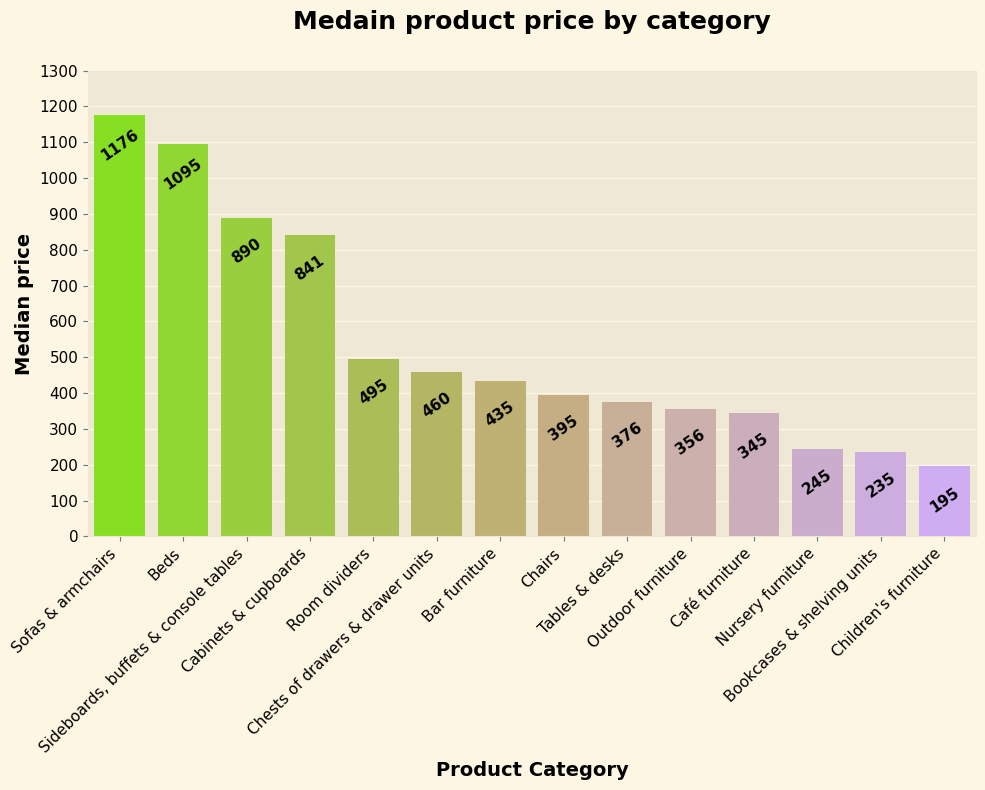

In [ ]:
plt.style.use('Solarize_Light2')
#plt.style.use('fivethirtyeight')
#plt.style.use('bmh')
#plt.style.use('ggplot')

gradient_colors_1 = sns.color_palette(f"blend:#89fe05,#d1b26f,#cea2fd", len(average_category_price))

plt.figure(figsize=(10, 8))
ax1 = sns.barplot(x=average_category_price.index, y=average_category_price.values, hue=average_category_price.index, palette=gradient_colors_1, legend=False)

plt.title('Medain product price by category', fontsize=18, fontweight='bold', pad=30)
plt.xlabel('Product Category', fontsize=14, fontweight='bold', color = 'black')
plt.ylabel('Median price', fontsize=14, fontweight='bold', color = 'black')
plt.xticks(rotation=45, ha='right', fontsize=11, color = 'black')
plt.yticks(fontsize=11, color = 'black')
plt.tight_layout()

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.ylim(0, 1300)

for container in ax1.containers:
    ax1.bar_label(container, padding=-35, fontsize=11, fontweight='bold', rotation=35)

plt.show()

The categories with the highest median prices are **Sofas & armchairs** and **Beds**, while the cheapest by median price are **Bookcases & shelving units** and **Children's furniture**.

---
Категорії з найвищими медіанними цінами - це **Sofas & armchairs** та **Beds**, тоді як найдешевші за медіанною ціною - це **Bookcases & shelving units** та **Children's furniture**.

### **Sales in the top 3 continents and the top 5 countries in each**

In [ ]:
# Знаходимо топ-3 континенти за загальною сумою продажів
# .nlargest(3) обирає топ 3 та сортує від найбільшого до найменшого
top_3_continents = company_data.groupby('continent')['product_price'].sum().nlargest(3).index
# Фільтруємо залишаючи тільки дані для топ-3 континентів
top_3_continents_df = company_data[company_data['continent'].isin(top_3_continents)][['session_id', 'continent', 'country', 'product_price']]

sales_by_country_and_continent = top_3_continents_df.groupby(['continent', 'country'])['product_price'].sum().reset_index()
# Сортуємо дані спочатку за континентом, а потім за продажами
sales_by_country_and_continent_sorted = sales_by_country_and_continent.sort_values(by=['continent', 'product_price'], ascending=[True, False])

# Вибираємо 5 найкращих країн для кожного континенту, використовуючи .head(5)
# .reset_index(drop=True) видаляє старий індекс і створює новий
top_5_countries_by_top_continent = sales_by_country_and_continent_sorted.groupby('continent').head(5).reset_index(drop=True)

# перетоврюємо колонку на категоріальну та встановлюємо порядок сортування 'continent' на основі списку топ-3 континентів (дозволяє нам сортувати за сумою продажів)
top_5_countries_by_top_continent['continent'] = pd.Categorical(top_5_countries_by_top_continent['continent'], categories=top_3_continents, ordered=True)
#Сортуємо фінальний датафрейм за цим новим порядком континентів та змінюємо ім' колонки
top_5_countries_by_top_continent_sorted = top_5_countries_by_top_continent.sort_values('continent').rename(columns={"product_price": "total_sales_sum"})

print('Sales by Top-3 Continents and Top-5 countries in each:')
top_5_countries_by_top_continent_sorted



Sales by Top-3 Continents and Top-5 countries in each:


,continent,country,total_sales_sum
0,Americas,United States,13943553.9
1,Americas,Canada,2437921.0
2,Americas,Brazil,339001.8
3,Americas,Mexico,272896.4
4,Americas,Peru,161221.5
5,Asia,India,2809762.0
6,Asia,China,588329.6
7,Asia,Taiwan,552710.3
8,Asia,Singapore,456447.2
9,Asia,Japan,417509.1


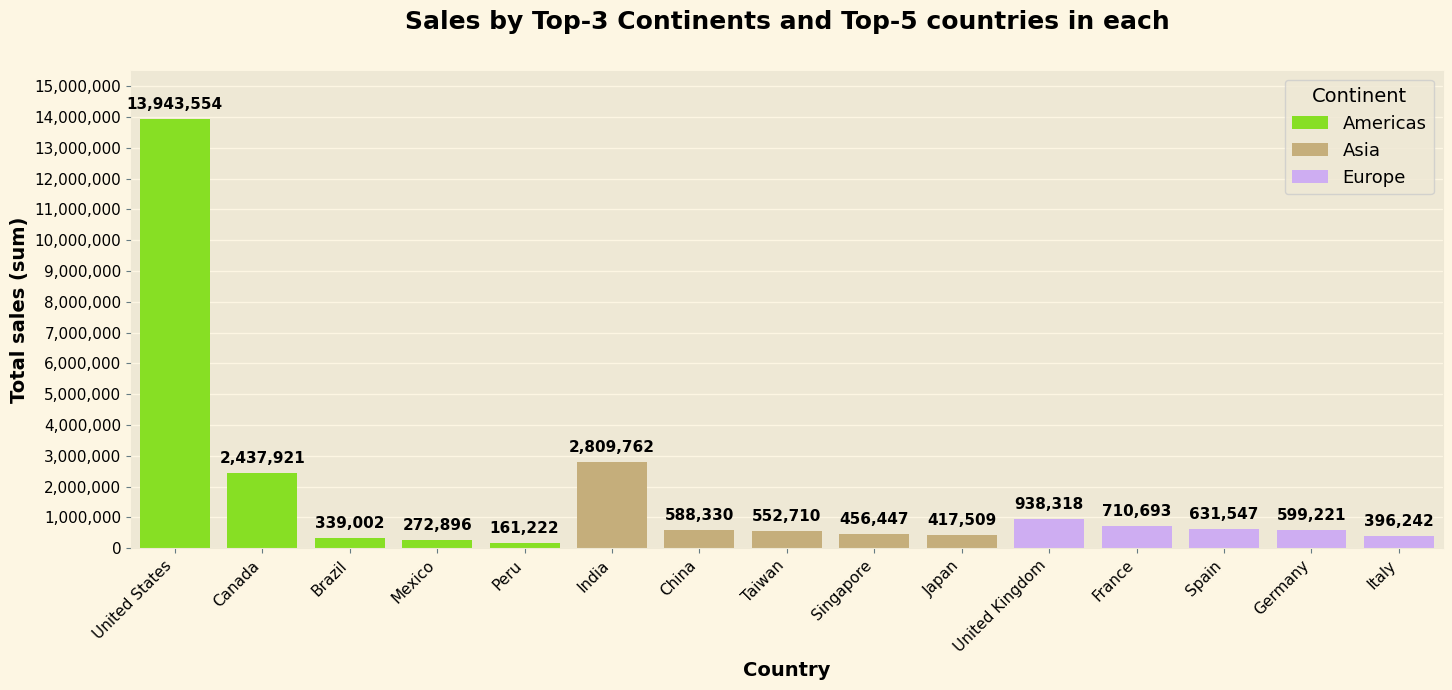

In [ ]:
plt.style.use('Solarize_Light2')
colors_2 = ['#89fe05', '#d1b26f', '#cea2fd']

plt.figure(figsize=(14, 7))
ax2 = sns.barplot(data=top_5_countries_by_top_continent_sorted, x='country', y='total_sales_sum', hue='continent', palette=colors_2)

# Add titles and labels
plt.title('Sales by Top-3 Continents and Top-5 countries in each', fontsize=18, fontweight='bold', pad=30)
plt.xlabel('Country', fontsize=14, fontweight='bold', color = 'black')
plt.ylabel('Total sales (sum)', fontsize=14, fontweight='bold', color = 'black')
plt.xticks(rotation=45, ha='right', fontsize=11, color = 'black')
plt.yticks(fontsize=11, color = 'black')
plt.legend(title='Continent', fontsize=13, title_fontsize=14)
plt.tight_layout()

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(1000000))
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylim(0, 15500000)

for container in ax2.containers:
    ax2.bar_label(container, padding=5, fontsize=11, fontweight='bold', rotation=0, color='black', fmt='{:,.0f}')

plt.show()

The largest continents by total sales are the **Americas, Asia, and Europe**. **The United States** stands out significantly among all countries on its own continent and across all others, securing the top position in sales with a significant lead and a total sales volume of approximately 14 million.

---

Найбільш великими за сумою продажів континентами є **Америки, Азія та Європа**. При цьому **Сполучені Штати** дуже сильно виділяються серед усіх країн як на своєму, так і на всіх інших континентах, займаючи перше місце в продажах зі значним відривом та загальною сумою продажів близько 14 млн.

### **Top 10 product categories by total sales**

In [ ]:
top_10_categories = company_data.groupby('product_category')['product_price'].sum().nlargest(10).index
top_10_categories_df = company_data[company_data['product_category'].isin(top_10_categories)][['session_id', 'product_category', 'product_price']]

top_10_categories_sales = pd.pivot_table(top_10_categories_df, values="product_price", index="product_category", aggfunc="sum").sort_values(by = "product_price", ascending = False).rename(columns={"product_price": "total_sales_sum"})

print('Sales by Top-10 product categories:')
top_10_categories_sales


Sales by Top-10 product categories:


,total_sales_sum
product_category,
Sofas & armchairs,8388254.5
Chairs,6147748.8
Beds,4919725.0
Bookcases & shelving units,3640818.1
Cabinets & cupboards,2336499.5
Outdoor furniture,2142222.2
Tables & desks,1790307.5
Chests of drawers & drawer units,906562.5
Bar furniture,735503.0


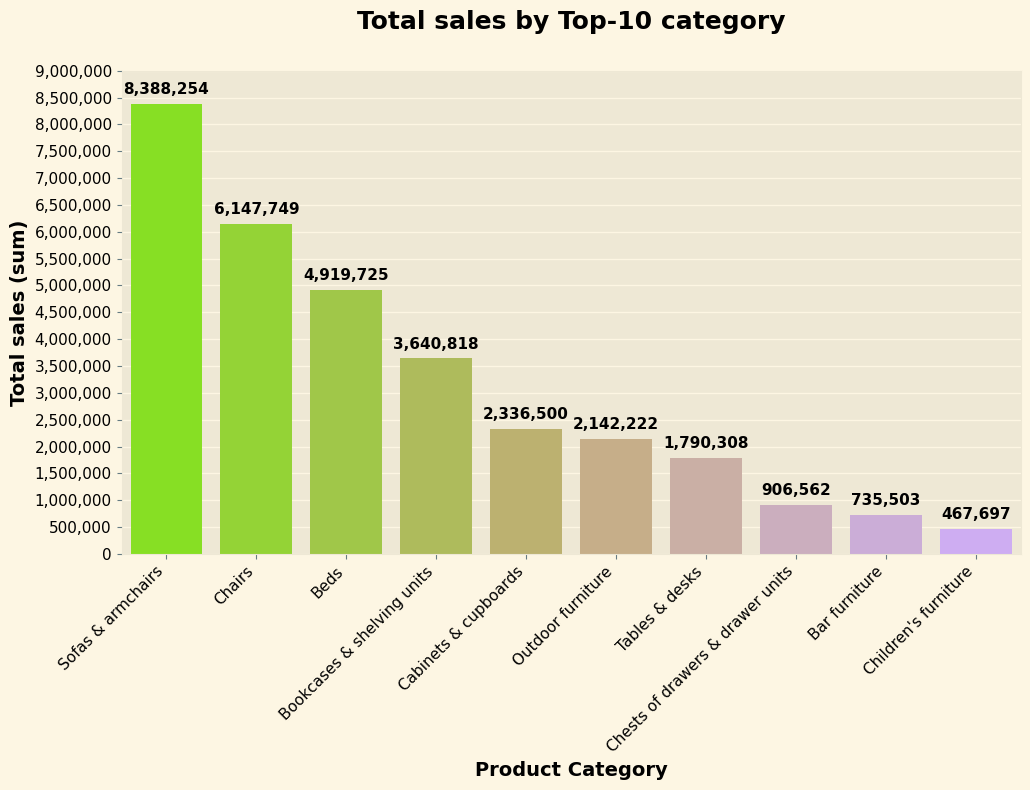

In [ ]:
plt.style.use('Solarize_Light2')

gradient_colors_3 = sns.color_palette(f"blend:#89fe05,#d1b26f,#cea2fd", len(top_10_categories_sales))

plt.figure(figsize=(10, 8))
ax3 = sns.barplot(data=top_10_categories_sales, x=top_10_categories_sales.index, y="total_sales_sum", hue=top_10_categories_sales.index, palette=gradient_colors_3, legend=False)

plt.title('Total sales by Top-10 category', fontsize=18, fontweight='bold', pad=30)
plt.xlabel('Product Category', fontsize=14, fontweight='bold', color = 'black')
plt.ylabel('Total sales (sum)', fontsize=14, fontweight='bold', color = 'black')
plt.xticks(rotation=45, ha='right', fontsize=11, color = 'black')
plt.yticks(fontsize=11, color = 'black')
plt.tight_layout()

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(500000))
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylim(0, 9000000)

for container in ax3.containers:
    ax3.bar_label(container, padding=5, fontsize=11, fontweight='bold', rotation=0, color='black', fmt='{:,.0f}')

plt.show()

**Top 10 product categories by total sales in the top country**

In [ ]:
# групуємо дані за країною і сумуємо продажі та сортуємо, щоб найбільша сума була нагорі
sales_by_country = company_data.groupby('country')['product_price'].sum().sort_values(ascending=False)
# Знаходимо максимальне значення продажів у країнах.
max_sales_country = sales_by_country.max()

# Фільтруємо за значенням max_sales_country і беремо індекс (назву країни) першого елемента
top_country = sales_by_country[sales_by_country == max_sales_country].index[0]
# Створюємо булеву маску
is_top_country = company_data['country'] == top_country

# фільтруємо дані за топ-країною, групуємо за категорією, сумуємо продажі і вибираємо 10 найбільших по індексам (назвам в даному випадку)
top_10_categories_in_top_country = company_data[is_top_country].groupby('product_category')['product_price'].sum().nlargest(10).index
# Створюємо булеву маску
is_top_10_category = company_data['product_category'].isin(top_10_categories_in_top_country)
# Фільтруємо оригінальний датафрейм за двому булевими масками, вибираємо потрібні колонки
top_10_categories_in_top_country_df = company_data[is_top_country & is_top_10_category][['session_id', 'product_category', 'country', 'product_price']]

# Групуємо за категорією і країною, сумуємо продажі та сортуємо
sales_top_10_categories_in_top_country = top_10_categories_in_top_country_df.groupby(['product_category', 'country'])['product_price'].sum().sort_values(ascending=False).reset_index()

print('Sales by Top-10 product categories in Top Country:')
sales_top_10_categories_in_top_country

Sales by Top-10 product categories in Top Country:


,product_category,country,product_price
0,Sofas & armchairs,United States,3707144.5
1,Chairs,United States,2619773.8
2,Beds,United States,2213058.0
3,Bookcases & shelving units,United States,1567606.9
4,Cabinets & cupboards,United States,994545.5
5,Outdoor furniture,United States,929245.2
6,Tables & desks,United States,777865.0
7,Chests of drawers & drawer units,United States,382388.0
8,Bar furniture,United States,330805.0
9,Children's furniture,United States,207575.0


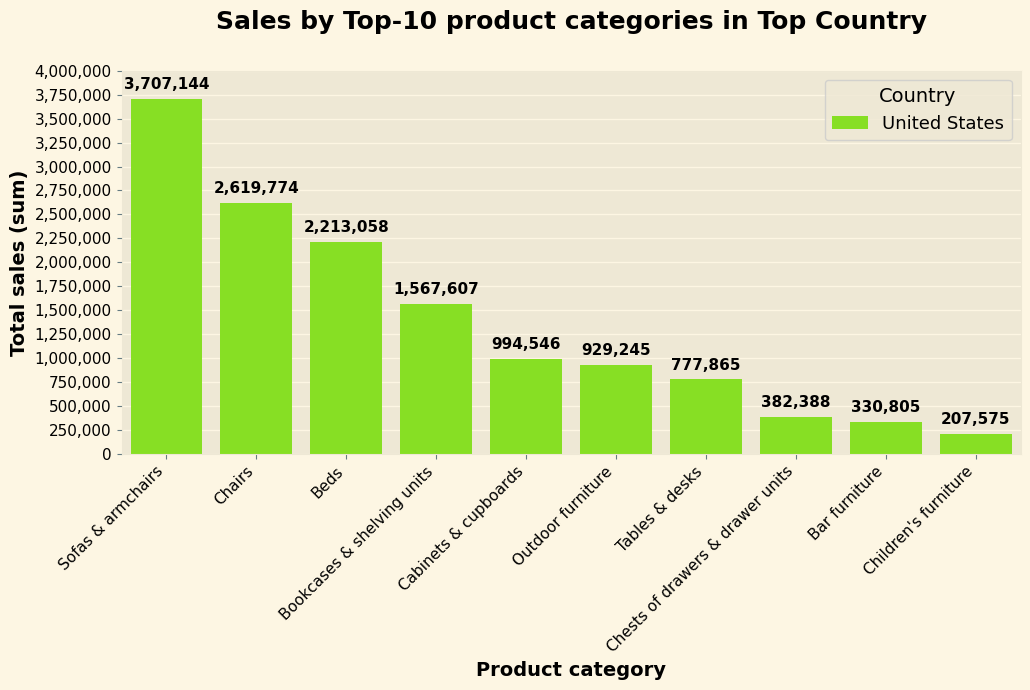

In [ ]:
plt.style.use('Solarize_Light2')
colors_4 = ['#89fe05']

plt.figure(figsize=(10, 7))
ax4 = sns.barplot(data=sales_top_10_categories_in_top_country, x="product_category", y='product_price', hue='country', palette=colors_4)

# Add titles and labels
plt.title('Sales by Top-10 product categories in Top Country', fontsize=18, fontweight='bold', pad=30)
plt.xlabel('Product category', fontsize=14, fontweight='bold', color = 'black')
plt.ylabel('Total sales (sum)', fontsize=14, fontweight='bold', color = 'black')
plt.xticks(rotation=45, ha='right', fontsize=11, color = 'black')
plt.yticks(fontsize=11, color = 'black')
plt.legend(title='Country', fontsize=13, title_fontsize=14)
plt.tight_layout()

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(250000))
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylim(0, 4000000)

for container in ax4.containers:
    ax4.bar_label(container, padding=5, fontsize=11, fontweight='bold', rotation=0, color='black', fmt='{:,.0f}')

plt.show()

When comparing sales across the top 10 categories in general and within the top country (USA), we can observe a similar trend where the categories have the same ranking by total sales. In both cases, the **Sofas & armchairs** category is the most profitable.

---
При порівнянні продажів по топ-10 категоріях у цілому та в розрізі однієї топ-країни (США), ми можемо спостерігати схожу тенденцію, коли категорії мають однаковий порядок за сумою продажів. У обох випадках категорія **Sofas & armchairs** є найбільш дохідною.

### **Sales by Top-5 Countries and Top-10 Categories**

In [ ]:
top_10_categories_2 = company_data.groupby('product_category')['product_price'].sum().nlargest(10).index
top_10_categories_2_df = company_data[company_data['product_category'].isin(top_10_categories_2)][['session_id', 'product_category', 'country', 'product_price']]

top_5_countries = company_data.groupby('country')['product_price'].sum().nlargest(5).index
top_10_categ_top_5_countries_df = top_10_categories_2_df[top_10_categories_2_df['country'].isin(top_5_countries)]

# Створюємо початкову зведену таблицю
top_10_categories_top_5_countreis_sales = pd.pivot_table(top_10_categ_top_5_countries_df, values="product_price", index="product_category", columns = "country", aggfunc="sum")

# Сортування стовпців за сумою продажів, обчислюємо суму для кожного стовпця і сортуємо, отримуємо індекси
sorted_columns = top_10_categories_top_5_countreis_sales.sum().sort_values(ascending=False).index
# Застосовуємо відсортований порядок до стовпців,  створюємо копію після сортування
top_10_categories_top_5_counteis_sales = top_10_categories_top_5_countreis_sales[sorted_columns].copy()

# Сортування рядків за сумою продажів (додаємо рядок з сумою)
top_10_categories_top_5_counteis_sales['category_total'] = top_10_categories_top_5_counteis_sales.sum(axis=1)
top_10_categories_top_5_counteis_sales = top_10_categories_top_5_counteis_sales.sort_values(by='category_total', ascending=False)

# Додаємо новий рядок із загальною сумою для кожної країни, сумуємо тільки стовпці з країнами
country_totals = top_10_categories_top_5_counteis_sales.sum()
top_10_categories_top_5_counteis_sales.loc['Country Total'] = country_totals

print("Sales by Top-5 Countries and Top-10 Categories:")
top_10_categories_top_5_counteis_sales

Sales by Top-5 Countries and Top-10 Categories:


country,United States,India,Canada,United Kingdom,France,category_total
product_category,,,,,,
Sofas & armchairs,3707144.5,788430.0,692427.5,234812.0,187735.0,5610549.0
Chairs,2619773.8,544309.2,417740.8,188519.4,134029.4,3904372.6
Beds,2213058.0,358319.5,354772.0,133816.0,116414.0,3176379.5
Bookcases & shelving units,1567606.9,364507.4,278981.9,113987.6,73830.0,2398913.8
Cabinets & cupboards,994545.5,191888.0,181802.0,71684.5,59101.5,1499021.5
Outdoor furniture,929245.2,162289.4,185322.8,57002.4,40486.4,1374346.2
Tables & desks,777865.0,186157.5,132678.0,49374.0,42299.0,1188373.5
Chests of drawers & drawer units,382388.0,73111.0,71952.0,36784.0,21544.5,585779.5
Bar furniture,330805.0,57657.0,51724.0,22103.0,11199.0,473488.0


From the table, we can see that the most profitable category is **Sofas & armchairs**, and the most profitable country is the **USA**. We can also see the total sales for each country and category.

---

З таблиці бачимо, що найбільш прибутковою категорією є **Sofas & armchairs**, а найбільш прибутковою країною — **США**. Також ми можемо побачити суму продажів по кожній країні та категорії.

### **Sales by devices**

In [ ]:
# Спочатку обчислюємо загальну суму продажів по всьому датафрейму
total_sales = company_data['product_price'].sum()

devices_sort_by_sales =  company_data.groupby(['device'])['product_price'].sum().index
sales_by_devices = company_data.groupby(['device', 'model_name'])['product_price'].sum().reset_index()

# Додаємо нову колонку з відсотковою часткою від загальної суми, кожне значення в колонці 'product_price' ділимо на загальну суму продажів і множимо на 100
sales_by_devices['percent_from_total'] = round((sales_by_devices['product_price'] / total_sales) * 100, 3)

# Перетворюємо колонку 'device' на категоріальну та встановлюємо порядок сортування
sales_by_devices['device'] = pd.Categorical(sales_by_devices['device'], categories=devices_sort_by_sales, ordered=True)

# Сортуємо спочатку за девайсом, а потім за відсотковою часткою
sales_by_devices_sorted = sales_by_devices.sort_values(by=['device', 'percent_from_total'], ascending=[True, False]).rename(columns={"product_price": "total_sales_sum"})

print("Sales by devices")
sales_by_devices_sorted

Sales by devices


,device,model_name,total_sales_sum,percent_from_total
0,desktop,Chrome,8899523.9,27.836
5,desktop,Safari,6490467.1,20.301
1,desktop,ChromeBook,1830458.7,5.725
2,desktop,Edge,696877.3,2.180
4,desktop,Other Model Name,525645.1,1.644
3,desktop,Firefox,421066.9,1.317
11,mobile,iPhone,6420776.3,20.083
7,mobile,Other Model Name,5735073.6,17.938
9,mobile,Pixel 4 XL,118287.7,0.370
8,mobile,Pixel 3,109148.2,0.341


According to the table, the largest share of sales is accounted for by the following combinations of devices and their types: **`desktop + Chrome`** — **27.8%**; **`desktop + Safari`** — **20.3%**; **`mobile + iPhone`** — **20%** and **`mobile + Other Model Name`** — **17.9%**.

---
Згідно з таблицею, найбільшу частку продажів займають такі комбінації девайсів та їх типів: **`desktop + Chrome`** — **27.8%**; **`desktop + Safari`** — **20.3%**; **`mobile + iPhone`** — **20%** та **`mobile + Other Model Name`** — **17.9%**.

### **Sales by traffic channel**

In [ ]:
sales_by_channel = pd.pivot_table(company_data, values="product_price", index="traffic_channel", aggfunc="sum").rename(columns={"product_price": "total_sales_sum"})
sales_by_channel["percent_from_total"] = round((sales_by_channel['total_sales_sum'] / total_sales) * 100, 3)
sales_by_channel_sorted = sales_by_channel.sort_values(by='percent_from_total', ascending=False).reset_index()

print("Sales by traffic channel")
sales_by_channel_sorted

Sales by traffic channel


,traffic_channel,total_sales_sum,percent_from_total
0,Organic Search,11433151.6,35.760
1,Paid Search,8511049.4,26.621
2,Direct,7494923.4,23.442
3,Social Search,2532105.7,7.920
4,Unknown Channel,2000501.0,6.257


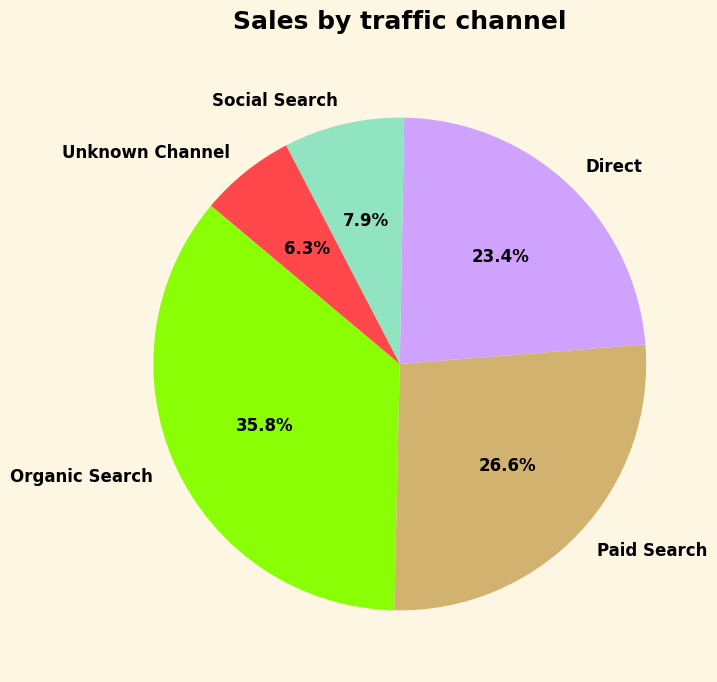

In [ ]:
plt.style.use('Solarize_Light2')
colors_4 = ['#89fe05', '#d1b26f', '#cea2fd', '#90e4c1', '#ff474c']

# Створення кругової діаграми
plt.figure(figsize=(9, 8))
plt.pie(sales_by_channel_sorted['percent_from_total'], labels=sales_by_channel_sorted['traffic_channel'],
    autopct='%1.1f%%', #налаштовує відображення відстоків на сегментах
    startangle=140, # налаштовує розщміщення сегментів
    textprops={'fontsize': 12, 'fontweight': 'bold'}, # Налаштування шрифту для відсотків та підписів
    colors=colors_4
)

plt.title('Sales by traffic channel', fontsize=18, fontweight='bold', pad=20)

plt.show()

As we can see from the diagram, **Organic Search** channel accounts for the largest share at **35.8%**, followed by **Paid Search** at **26.6%** and **Direct** at **23.4%**.

---

Як бачимо з діаграми, найбільшу частку займає канал **Organic Search** — **35.8%**, далі ідуть **Paid Search** — **26.6%** та **Direct** — **23.4%**.

### **The number of sessions by traffic channel and device**

In [ ]:
num_sesion_chan_device = pd.pivot_table(company_data, values="session_id", index="traffic_channel", columns = "device", aggfunc="count")
# Сортування стовпців за кількістю сесій, отримуємо індекси
sorted_columns_num_sesion_chan_device = num_sesion_chan_device.sum().sort_values(ascending=False).index
# Застосовуємо відсортований порядок до стовпців,  створюємо копію після сортування
num_sesion_chan_device = num_sesion_chan_device[sorted_columns_num_sesion_chan_device].copy()

# Сортування рядків за кількістю сесій (додаємо рядок з сумою)
num_sesion_chan_device['traffic_channel_total'] = num_sesion_chan_device.sum(axis=1)
num_sesion_chan_device = num_sesion_chan_device.sort_values(by='traffic_channel_total', ascending=False)

# Додаємо новий рядок із загальною сумою для кожної країни, сумуємо тільки стовпці з країнами
device_totals = num_sesion_chan_device.sum()
num_sesion_chan_device.loc['Device Total'] = device_totals

print("Number of sessions by device and traffic channel:")
num_sesion_chan_device



Number of sessions by device and traffic channel:


device,desktop,mobile,tablet,traffic_channel_total
traffic_channel,,,,
Organic Search,72622,49014,2789,124425
Paid Search,55167,37034,2140,94341
Direct,47825,31745,1812,81382
Social Search,16288,10988,638,27914
Unknown Channel,12527,8486,470,21483
Device Total,204429,137267,7849,349545


In [ ]:
# Видаляємо рядки з 'Device Total' та 'Unknown Channel'
num_sesion_chan_device_drop_totals = num_sesion_chan_device.drop(['Device Total', 'Unknown Channel']).drop('traffic_channel_total', axis=1).reset_index()

# Перетворюємо DataFrame з широкого формату на довгий
# id_vars: 'traffic_channel' стане ідентифікаційною змінною
# var_name: 'device' - нова колонка, в яку потраплять назви старих колонок (Desktop, Mobile, Tablet)
# value_name: 'session_count' - нова колонка, в яку потраплять значення сесій
# melt - з широкого формату на довгий
num_sesion_chan_device_drop_totals_long = num_sesion_chan_device_drop_totals.melt(id_vars=['traffic_channel'], var_name='device', value_name='session_count')
num_sesion_chan_device_drop_totals_long

,traffic_channel,device,session_count
0,Organic Search,desktop,72622
1,Paid Search,desktop,55167
2,Direct,desktop,47825
3,Social Search,desktop,16288
4,Organic Search,mobile,49014
5,Paid Search,mobile,37034
6,Direct,mobile,31745
7,Social Search,mobile,10988
8,Organic Search,tablet,2789
9,Paid Search,tablet,2140


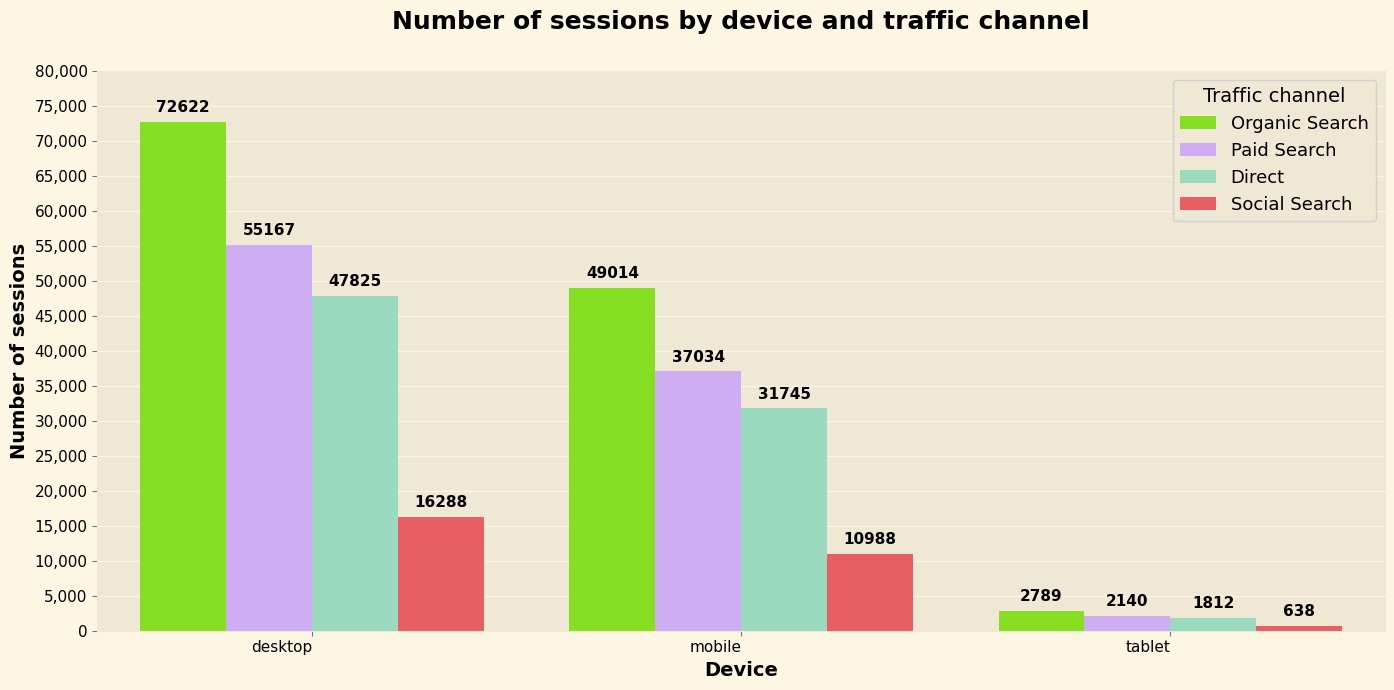

In [ ]:
plt.style.use('Solarize_Light2')
colors_5 = ['#89fe05', '#cea2fd', '#90e4c1', '#ff474c']

plt.figure(figsize=(14, 7))
ax5 = sns.barplot(data=num_sesion_chan_device_drop_totals_long, y='session_count', x='device', hue='traffic_channel', palette=colors_5)

# Add titles and labels
plt.title('Number of sessions by device and traffic channel', fontsize=18, fontweight='bold', pad=30)
plt.xlabel('Device', fontsize=14, fontweight='bold', color = 'black')
plt.ylabel('Number of sessions', fontsize=14, fontweight='bold', color = 'black')
plt.xticks(rotation=0, ha='right', fontsize=11, color = 'black')
plt.yticks(fontsize=11, color = 'black')
plt.legend(title='Traffic channel', fontsize=13, title_fontsize=14)
plt.tight_layout()

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(5000))
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylim(0, 80000)

for container in ax5.containers:
    ax5.bar_label(container, padding=5, fontsize=11, fontweight='bold', rotation=0, color='black', fmt='{:.0f}')

plt.show()

The largest number of sessions comes from **desktop** devices, with **mobile** taking second place, and **tablet** being the least popular. The distribution of traffic channels does not depend on the device type and is the same for all: most users come from **organic search**, followed by **paid search**, with **social media** in last place.

---
Найбільша кількість сесій відбувається з приладів типу **desktop**, друге місце посідає **mobile**, а найменш популярним є **tablet**. Розподіл каналів трафіку не залежить від типу приладів і є однаковим для всіх: найбільше користувачів приходить з **органічного пошуку**, на другому місці **платний пошук**, а останнє місце посідають **соціальні мережі**.

### **The number of sessions by browser**

In [ ]:
total_sessions = company_data['session_id'].count()
sessions_by_browser = pd.pivot_table(company_data, values="session_id", index="browser", aggfunc="count")
sessions_by_browser["percent_from_total"] = round((sessions_by_browser['session_id'] / total_sessions) * 100, 2)
sessions_by_browser_sorted = sessions_by_browser.sort_values(by='percent_from_total', ascending=False).reset_index()

print("The number of sessions by browser")
sessions_by_browser_sorted

The number of sessions by browser


,browser,session_id,percent_from_total
0,Chrome,238460,68.22
1,Safari,83254,23.82
2,Other Browser,8930,2.55
3,Edge,8023,2.30
4,Firefox,6433,1.84
5,Android Webview,4445,1.27


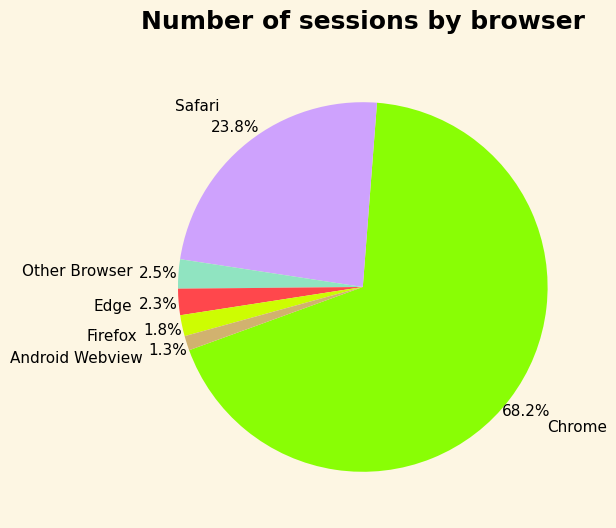

In [ ]:
plt.style.use('Solarize_Light2')
colors_6 = ['#89fe05',  '#cea2fd', '#90e4c1', '#ff474c', '#cdfd02', '#d1b26f']

# Створення кругової діаграми
plt.figure(figsize=(8, 6))
plt.pie(sessions_by_browser_sorted['percent_from_total'], labels=sessions_by_browser_sorted['browser'],
    autopct='%1.1f%%', #налаштовує відображення відстоків на сегментах
    startangle=200, # налаштовує розщміщення сегментів
    textprops={'fontsize': 11, 'fontweight': 'regular'}, # Налаштування шрифту для відсотків та підписів
    colors=colors_6,
    labeldistance=1.25,  # Переміщує підписи далі від центру
    pctdistance=1.11,   # Переміщує відсотки від центру
)

plt.title('Number of sessions by browser', fontsize=18, fontweight='bold', pad=20)

plt.show()

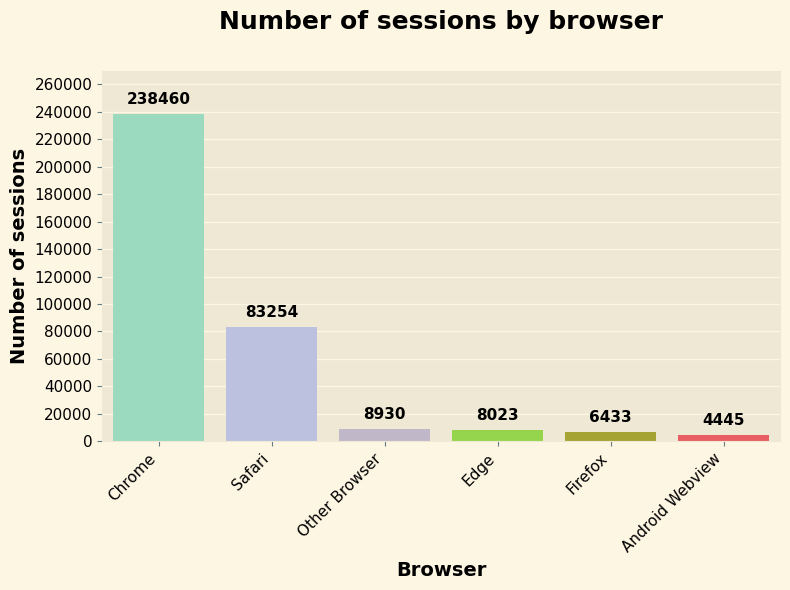

In [ ]:
plt.style.use('Solarize_Light2')

gradient_colors_55 = sns.color_palette(f"blend:#ff474c,#89fe05,#cea2fd,#90e4c1", len(sessions_by_browser_sorted['percent_from_total']))

plt.figure(figsize=(8, 6))
ax55 = sns.barplot(data=sessions_by_browser_sorted, x="browser", y="session_id", hue="percent_from_total", palette=gradient_colors_55, legend=False)

plt.title('Number of sessions by browser', fontsize=18, fontweight='bold', pad=30)
plt.xlabel('Browser', fontsize=14, fontweight='bold', color = 'black')
plt.ylabel('Number of sessions', fontsize=14, fontweight='bold', color = 'black')
plt.xticks(rotation=45, ha='right', fontsize=11, color = 'black')
plt.yticks(fontsize=11, color = 'black')
plt.tight_layout()

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(20000))
#plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylim(0, 270000)

for container in ax55.containers:
    ax55.bar_label(container, padding=5, fontsize=11, fontweight='bold', rotation=0, color='black', fmt='{:.0f}')

plt.show()

The most popular browsers are **Chrome** and **Safari**, which together account for about **90%** of visits. This indicates that the website should be optimized primarily for them.

---
Найбільш популярними браузерами є **Chrome** та **Safari**, які разом займають близько **90%** відвідувань, що свідчить про необхідність оптимізації сайту в першу чергу саме під них.



### **Users status**

In [ ]:
# Порахуємо загальну кількість унікальних корситувачів, виключаємо рядки Guest
total_users = company_data[company_data['account_id'] != 'Guest']['account_id'].nunique()
# а також загальну кількість сесій де вказано account_id для порівняння
total_users_sessions = company_data[company_data['account_id'] != 'Guest']['session_id'].count()
print(f"""Total users sessions: {total_users_sessions}
Number of users: {total_users}""")

Total users sessions: 27945
Number of users: 27945


Each user has only one session, which was found during the dataset analysis and is now confirmed by this calculation.

---
Кожен користувач має лише одну сесію, що було з'ясовано під час дослідження датасету та підтверджено зараз за допомогою цього розрахунку.

In [ ]:
# Фільтруємо дані, виключаючи 'Guest'
user_status_filtered = company_data[(company_data['is_verified'] != 'Guest') & (company_data['is_subscribed'] != 'Guest')].copy()

# Групуємо за двома колонками та підраховуємо сесії
user_status_sessions = user_status_filtered.pivot_table(values="account_id", index="is_verified", aggfunc="count")
# Додамо колонку з відсотками
user_status_sessions['percent_from_total'] = round((user_status_sessions['account_id'] / total_users) * 100, 2)

user_status_sessions_sorted = user_status_sessions.sort_values(by= 'percent_from_total', ascending= False).reset_index()
print("Number of verified users accounts")
user_status_sessions_sorted

Number of verified users accounts


,is_verified,account_id,percent_from_total
0,Yes,20036,71.7
1,No,7909,28.3


In [ ]:
# Групуємо за двома колонками та підраховуємо сесії
user_subscribed_sessions = user_status_filtered.pivot_table(values="account_id", index="is_subscribed", aggfunc="count")
# Додамо колонку з відсотками
user_subscribed_sessions['percent_from_total'] = round((user_subscribed_sessions['account_id'] / total_users) * 100, 2)

user_subscribed_sessions_sorted = user_subscribed_sessions.sort_values(by= 'percent_from_total', ascending= False).reset_index()
print("Number of subscribed users")
user_subscribed_sessions_sorted

Number of subscribed users


,is_subscribed,account_id,percent_from_total
0,Yes,23210,83.06
1,No,4735,16.94


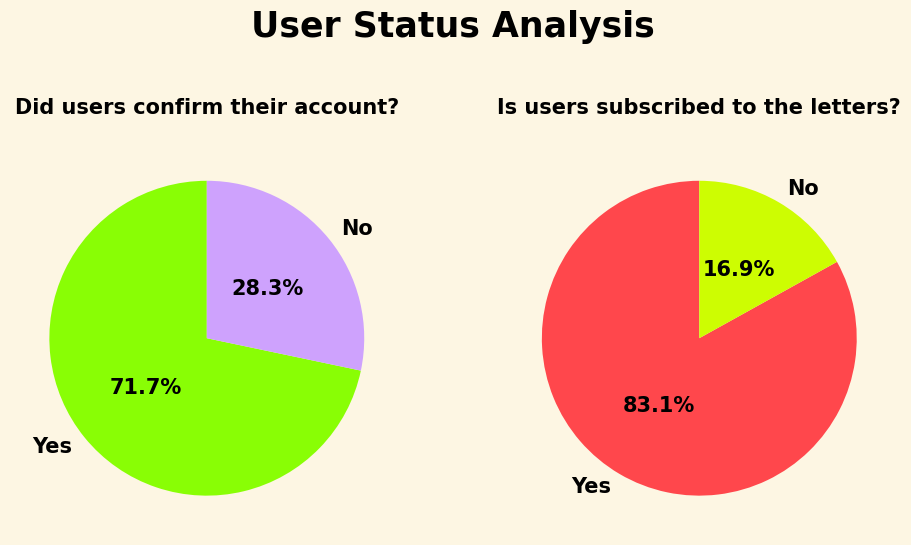

In [ ]:
# Налаштування стилів
plt.style.use('Solarize_Light2')
colors_7 = ['#89fe05', '#cea2fd']
colors_8 = ['#ff474c', '#cdfd02']

# Створення фігури
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Створення першої кругової діаграми на першій осі axes[0]
axes[0].pie(user_status_sessions_sorted['percent_from_total'], labels=user_status_sessions_sorted['is_verified'],
    autopct='%1.1f%%', # Налаштовує формат відсотків (одна цифра після коми)
    startangle=90, # Починає перший сегмент під кутом 90 градусів
    textprops={'fontsize': 15, 'fontweight': 'bold'}, # Налаштовує шрифт для відсотків і підписів
    colors=colors_7,# Задає кольори для сегментів діаграми
    labeldistance=1.1, # Переміщує підписи від центру
    pctdistance=0.5, # Налаштовує відстань відсотків від центру
)

# Встановлюємо заголовок
axes[0].set_title('Did users confirm their account?', fontsize=15, fontweight='bold', pad=20)

# Створення другої кругової діаграми на другій осі axes[1]
axes[1].pie(    user_subscribed_sessions_sorted['percent_from_total'], labels=user_subscribed_sessions_sorted['is_subscribed'],
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 15, 'fontweight': 'bold'},
    colors=colors_8,
    labeldistance=1.1,
    pctdistance=0.5,
)

# Встановлюємо заголовок для другої діаграми
axes[1].set_title('Is users subscribed to the letters?', fontsize=15, fontweight='bold', pad=20)

# Додаємо загальний заголовок
fig.suptitle('User Status Analysis', fontsize=25, fontweight='bold', y=1.08) # y=1.03 піднімає заголовок вище
plt.tight_layout()
plt.show()

Among registered users, **71.7%** confirmed their account, and **83.1%** subscribed to the newsletter.

---

Серед зареєстрованих користувачів **71.7%** підтвердили свій акаунт, і **83.1%** підписалися на розсилку.

### **Sales of registered and unregistered users by traffic channel**

In [ ]:
# Створимо колонку 'user_type'

def set_user_type(account_id):
    if account_id != 'Guest':
        return 'Registered user'
    else:
        return 'Unregistered user'

company_data['user_type'] = company_data['account_id'].apply(set_user_type)

# Відсортуємо тип корситувача за продажам і дістанемо порядок за допомогою index
user_type_sortered = company_data.groupby(['user_type'])['product_price'].sum().sort_values(ascending=False).index

# Групуємо за типом користувача та каналом трафіку
sales_by_user_type_and_channel = company_data[company_data['traffic_channel'] != 'Unknown Channel'].groupby(['user_type', 'traffic_channel'])['product_price'].sum().reset_index()

# Перетворюємо колонку 'user_type' на категоріальну та встановлюємо порядок сортування
sales_by_user_type_and_channel['user_type'] = pd.Categorical(sales_by_user_type_and_channel['user_type'], categories=user_type_sortered, ordered=True)

# Сортуємо спочатку за типом, а потім за сумою та переіменуємо колонку
sales_by_user_type_and_channel = sales_by_user_type_and_channel.sort_values(by=['user_type', 'product_price'], ascending=[True, False]).rename(columns={"product_price": "total_sales_sum"})

print("Sales by users type and channels")
sales_by_user_type_and_channel

Sales by users type and channels


,user_type,traffic_channel,total_sales_sum
5,Unregistered user,Organic Search,10498822.1
6,Unregistered user,Paid Search,7870249.8
4,Unregistered user,Direct,6885986.2
7,Unregistered user,Social Search,2326965.8
1,Registered user,Organic Search,934329.5
2,Registered user,Paid Search,640799.6
0,Registered user,Direct,608937.2
3,Registered user,Social Search,205139.9


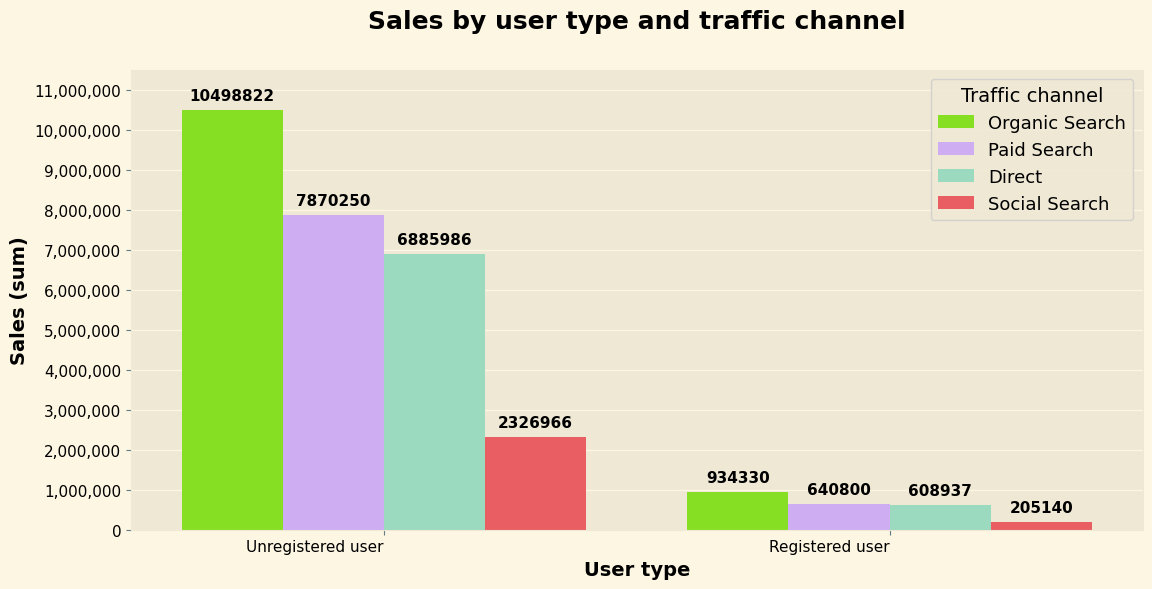

In [ ]:
plt.style.use('Solarize_Light2')
colors_9 = ['#89fe05', '#cea2fd', '#90e4c1', '#ff474c']

plt.figure(figsize=(11, 6))
ax9 = sns.barplot(data=sales_by_user_type_and_channel, y='total_sales_sum', x='user_type', hue='traffic_channel', palette=colors_9)

# Add titles and labels
plt.title('Sales by user type and traffic channel', fontsize=18, fontweight='bold', pad=30)
plt.xlabel('User type', fontsize=14, fontweight='bold', color = 'black')
plt.ylabel('Sales (sum)', fontsize=14, fontweight='bold', color = 'black')
plt.xticks(rotation=0, ha='right', fontsize=11, color = 'black')
plt.yticks(fontsize=11, color = 'black')
plt.legend(title='Traffic channel', fontsize=13, title_fontsize=14)
plt.tight_layout()

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(1000000))
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylim(0, 11500000)

for container in ax9.containers:
    ax9.bar_label(container, padding=5, fontsize=11, fontweight='bold', rotation=0, color='black', fmt='{:.0f}')

plt.show()

The vast majority of purchases are made by **unregistered users**. The dominance of the **organic traffic channel** remains consistent for both user types. The distribution of traffic channels across user types is identical and follows the overall trend.

---

Переважна більшість покупок відбувається **незареєстрованими користувачами**. При цьому для обох типів користувачів зберігається домінування **органічного каналу трафіку**. Розподіл каналів трафіку між типами користувачів однаковий і відповідає загальній тенденції.

## **Sales dynamics analysis**

### **Overall sales dynamics compared to expected revenue**

Let's compare the dynamics of expected revenue with actual sales. We'll filter out `NaN` values to exclude days with no orders. We can use any aggregate function like `min`, `max`, or `mean`, as they will give us the same value because each row contains the total revenue for that date. In this case, using `sum` is incorrect.

---

Порівняємо динаміку очікуваного доходу з реальними продажами. Відфільтруємо значення `NaN`, щоб виключити дні, в які не було замовлень. Ми можемо використати будь-яку агрегатну функцію (`min`, `max`, `mean`), оскільки вони дадуть нам однакове значення, адже в кожному рядку ми маємо загальний дохід за дату. Використання `sum` у цьому випадку є некоректним.

In [ ]:
sales_dynamics = company_data[company_data['total_daily_revenue'].notna()].groupby(['session_date'], observed=True)[['daily_revenue_predict', 'total_daily_revenue']].mean().reset_index()

print('Sales dynamics and expected revenue by date')

sales_dynamics

Sales dynamics and expected revenue by date


,session_date,daily_revenue_predict,total_daily_revenue
0,2020-11-01,351952.020,244292.5
1,2020-11-02,547192.038,355506.8
2,2020-11-03,737844.352,498979.6
3,2020-11-04,472059.162,339187.1
4,2020-11-05,574365.168,391276.6
...,...,...,...
83,2021-01-23,418842.855,290605.5
84,2021-01-24,365542.291,243818.4
85,2021-01-25,442304.081,305089.3
86,2021-01-26,569533.230,372057.3


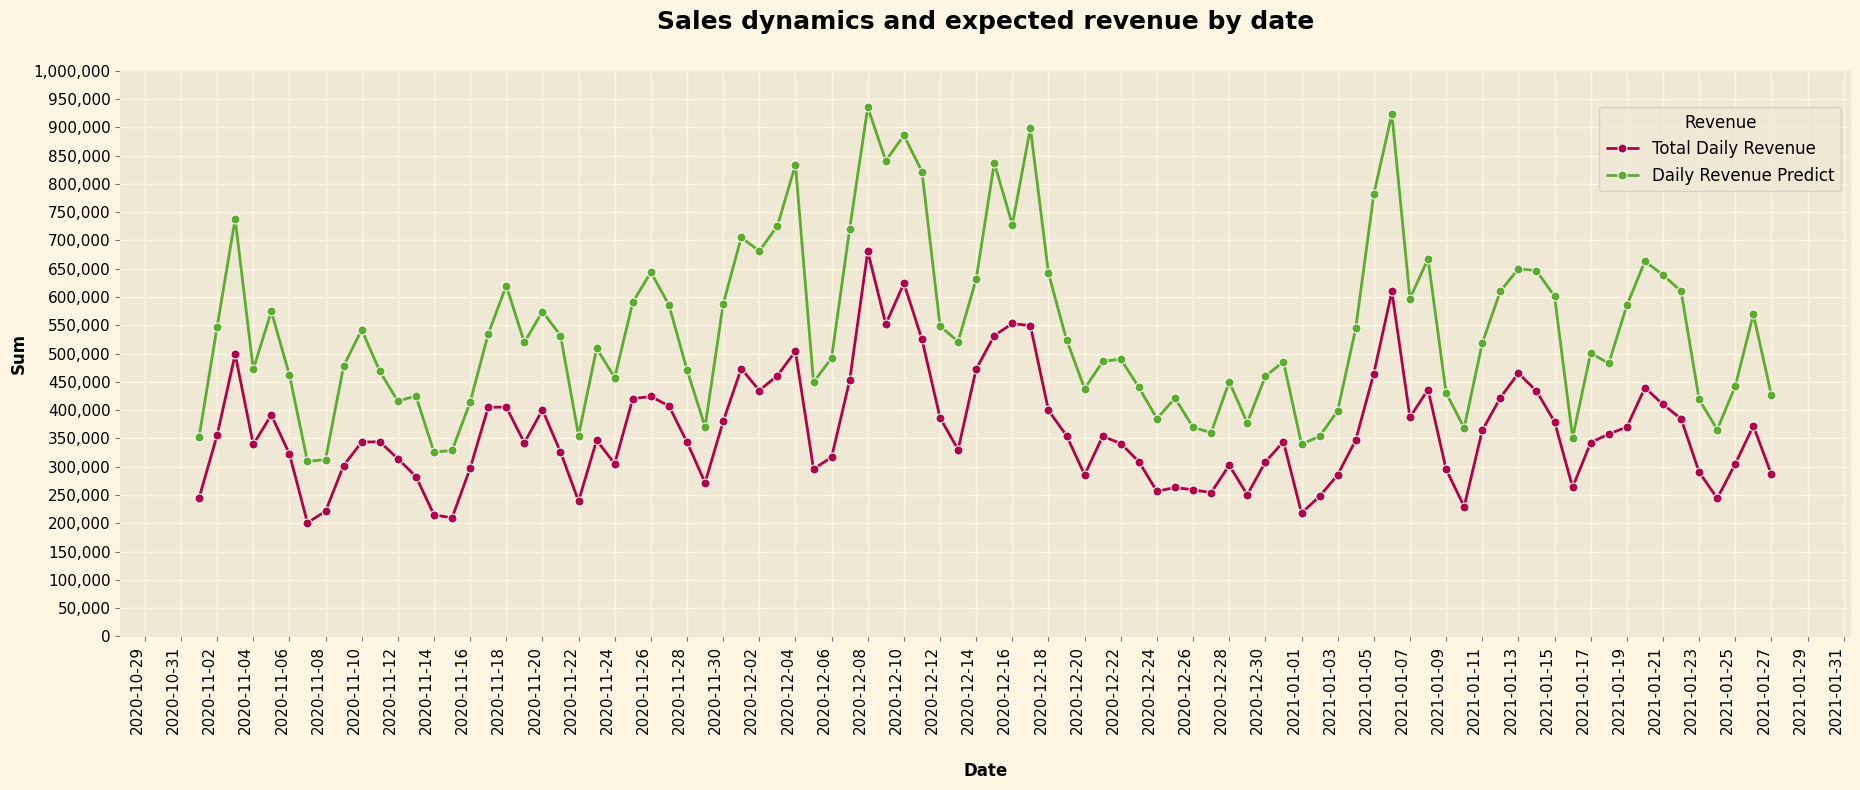

In [ ]:
# Встановлення стилю
plt.style.use('Solarize_Light2')

# Створення фігури
plt.figure(figsize=(19, 8))

# Створення графіка для 'total_daily_revenue'
sns.lineplot(
    data=sales_dynamics,
    x='session_date',
    y='total_daily_revenue',
    label='Total Daily Revenue',  # Підпис для легенди
    marker='o',
    markersize=6.5,
    color = '#b00149'   #'#ae7181' #'#01ff07' # '#d1b26f' #
)

# Створення графіка для 'daily_revenue_predict'
sns.lineplot(
    data=sales_dynamics,
    x='session_date',
    y='daily_revenue_predict',
    label='Daily Revenue Predict', # Підпис для легенди
    marker='o',
    markersize=6.5,
    color = '#5cac2d'   # '#5cac2d' #'#ae7181' #'#fc5a50'
)

# Додавання заголовків та підписів
plt.title('Sales dynamics and expected revenue by date', fontsize=18, fontweight='bold', pad=30)
plt.xlabel('Date', fontsize=12, fontweight='bold', color='black', labelpad=20)
plt.ylabel('Sum', fontsize=12, fontweight='bold', color='black')
plt.xticks(rotation=90, ha='right', fontsize=11, color='black')
plt.yticks(fontsize=11, color='black')

# Налаштування міток осей. Використовуємо Locator, щоб відображати кожну n мітку,
ax10 = plt.gca() #функція повертає об'єкт осей (Axes), на який зараз налаштована робота Matplotlib
ax10.xaxis.set_major_locator(ticker.MultipleLocator(2))
# Налаштування формату осі Y
ax10.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax10.yaxis.set_major_locator(ticker.MultipleLocator(50000))

plt.ylim(0, 1000000)

# Відображення легенди
plt.legend(title='Revenue', bbox_to_anchor=(0.85, 0.95), loc='upper left', fontsize=12, title_fontsize=12)

plt.tight_layout()
plt.show()

The dynamics of expected and actual revenue largely coincide, which indicates that the forecasts regarding revenue growth and declines on specific days are accurate. However, the level of actual revenue is always lower than the forecasted amount. The most profitable days were December 6, December 12, and January 6. The least profitable days were November 7, November 16, and January 10. Overall, the revenue remains at a fairly stable level in the range of 200,000 to 600,000.

---

Динаміка очікуваного та реального доходу переважно збігається, що свідчить про те, що прогнози щодо зростання та спадів доходу в певні дні є вірними. Однак, рівень реального доходу завжди менший за прогнозований. Найбільш прибуткові дні — це 6 грудня, 12 грудня та 6 січня. Найменш прибуткові дні — 7 листопада, 16 листопада та 10 січня. Загалом, дохід тримається на доволі стабільному рівні в діапазоні від 200 000 до 600 000.

### **Weekday sales dynamics**

In [ ]:
weekday_sales_dynamics = company_data[company_data['total_daily_revenue'].notna()].groupby(['weekday'], observed=True)[['product_price']].sum().round(2).reset_index().rename(columns={"product_price": "total_sales_sum"})

print('Sales dynamics and expected revenue by weekday')

weekday_sales_dynamics

Sales dynamics and expected revenue by weekday


,weekday,total_sales_sum
0,Monday,4636290.4
1,Tuesday,5457515.9
2,Wednesday,5466542.9
3,Thursday,4936935.6
4,Friday,4523067.2
5,Saturday,3477990.9
6,Sunday,3473388.2


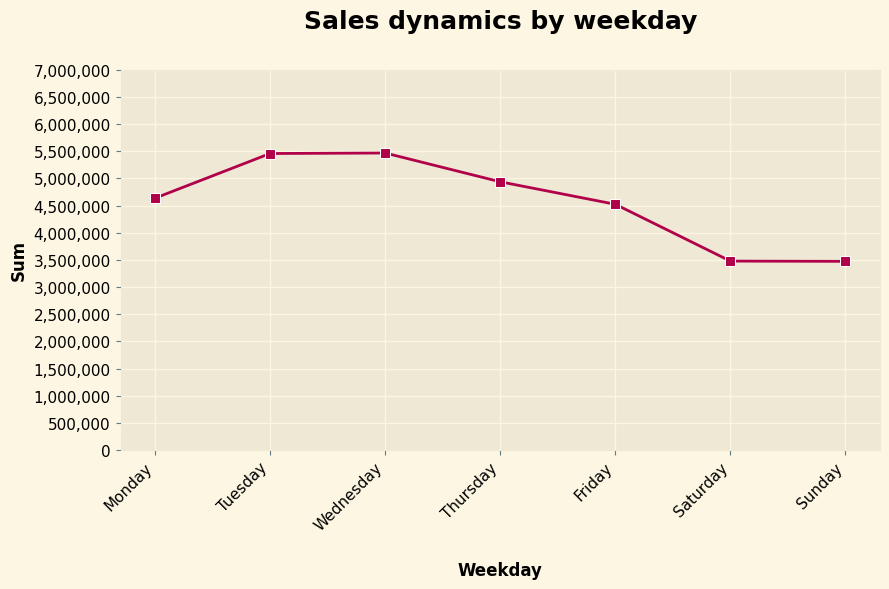

In [ ]:
# Встановлення стилю
plt.style.use('Solarize_Light2')

# Створення фігури
plt.figure(figsize=(9, 6))

# Створення графіка для 'total_daily_revenue'
sns.lineplot(
    data=weekday_sales_dynamics,
    x='weekday',
    y='total_sales_sum',
    marker='s',
    markersize=7.5,
    color = '#b00149'   #'#ae7181' #'#01ff07' # '#d1b26f' #
)


# Додавання заголовків та підписів
plt.title('Sales dynamics by weekday', fontsize=18, fontweight='bold', pad=30)
plt.xlabel('Weekday', fontsize=12, fontweight='bold', color='black', labelpad=20)
plt.ylabel('Sum', fontsize=12, fontweight='bold', color='black')
plt.xticks(rotation=45, ha='right', fontsize=11, color='black')
plt.yticks(fontsize=11, color='black')

# Налаштування міток осей. Використовуємо Locator, щоб відображати кожну n мітку,
ax11 = plt.gca() #функція повертає об'єкт осей (Axes), на який зараз налаштована робота Matplotlib
ax11.xaxis.set_major_locator(ticker.MultipleLocator(1))
# Налаштування формату осі Y
ax11.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax11.yaxis.set_major_locator(ticker.MultipleLocator(500000))

plt.ylim(0, 7000000)

plt.tight_layout()
plt.show()

Revenue throughout the week remains relatively stable, fluctuating between 3.5 million and 5.5 million. The highest revenue is observed on **Tuesdays** and **Wednesdays**, while the lowest is on **Saturdays** and **Sundays**.

---

Дохід протягом тижня залишається приблизно стабільним, коливаючись у діапазоні від 3.5 до 5.5 мільйонів. Найбільший дохід спостерігається у **вівторок** та **середу**, найменший — у **суботу** та **неділю**.

### **Sales dynamics of registered and unregistered users**

In [ ]:
# з попередніх кроків ми маємо вже колонку з типом юзера

# Групуємо за типом користувача та датою
sales_by_user_type_and_date = company_data[company_data['total_daily_revenue'].notna()].groupby(['session_date', 'user_type'])['product_price'].sum().reset_index().rename(columns={"product_price": "total_sales_sum"})

print("Sales by users type and date")
sales_by_user_type_and_date

Sales by users type and date


,session_date,user_type,total_sales_sum
0,2020-11-01,Registered user,21547.0
1,2020-11-01,Unregistered user,222745.5
2,2020-11-02,Registered user,44956.8
3,2020-11-02,Unregistered user,310550.0
4,2020-11-03,Registered user,29150.5
...,...,...,...
171,2021-01-25,Unregistered user,270925.5
172,2021-01-26,Registered user,27213.6
173,2021-01-26,Unregistered user,344843.7
174,2021-01-27,Registered user,14613.6


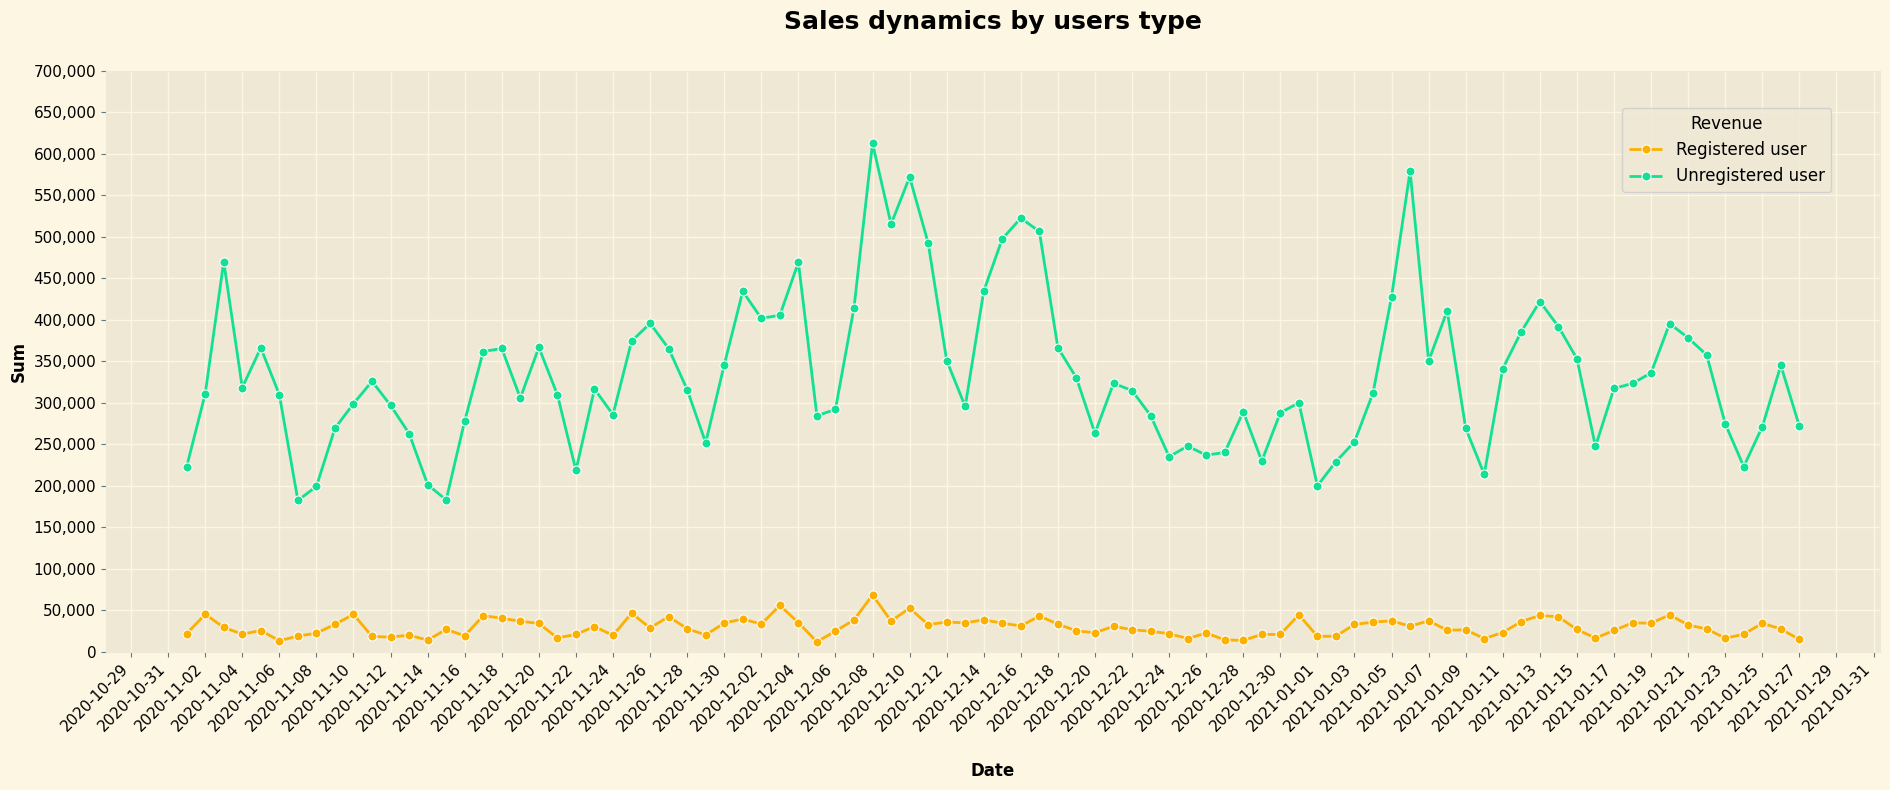

In [ ]:
# Встановлення стилю
plt.style.use('Solarize_Light2')
colors_12 =  ['#fcb001', '#12e193']

# Створення фігури
plt.figure(figsize=(19, 8))

# Створення графіка для 'total_daily_revenue'
sns.lineplot(
    data=sales_by_user_type_and_date,
    x='session_date',
    y='total_sales_sum',
    hue='user_type',
    marker='o',
    markersize=6.5,
    palette = colors_12
)


# Додавання заголовків та підписів
plt.title('Sales dynamics by users type', fontsize=18, fontweight='bold', pad=30)
plt.xlabel('Date', fontsize=12, fontweight='bold', color='black', labelpad=20)
plt.ylabel('Sum', fontsize=12, fontweight='bold', color='black')
plt.xticks(rotation=45, ha='right', fontsize=11, color='black')
plt.yticks(fontsize=11, color='black')

# Налаштування міток осей. Використовуємо Locator, щоб відображати кожну n мітку,
ax12 = plt.gca() #функція повертає об'єкт осей (Axes), на який зараз налаштована робота Matplotlib
ax12.xaxis.set_major_locator(ticker.MultipleLocator(2))
# Налаштування формату осі Y
ax12.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax12.yaxis.set_major_locator(ticker.MultipleLocator(50000))

plt.ylim(0, 700000)

# Відображення легенди
plt.legend(title='Revenue', bbox_to_anchor=(0.85, 0.95), loc='upper left', fontsize=12, title_fontsize=12)


plt.tight_layout()
plt.show()

The sales dynamics of registered and unregistered users are approximately the same in terms of daily peaks and declines. However, registered users generate significantly less revenue than unregistered ones.

---

Динаміка продажів зареєстрованих та незареєстрованих користувачів приблизно збігається по днях підйому та спадання. Однак, зареєстровані користувачі приносять набагато менше доходу, ніж незареєстровані.

### **Sales dynamics by Top-5 countries**

In [ ]:
#top5 країн ми визначили раніше
top_5_countries_df = company_data[company_data['country'].isin(top_5_countries)]
top_5_countries_sales_dynamics = top_5_countries_df[top_5_countries_df['total_daily_revenue'].notna()].groupby(['session_date', 'country'])['product_price'].sum().reset_index()
top_5_countries_sales_dynamics = top_5_countries_sales_dynamics.rename(columns={"product_price": "total_sales_sum"})
top_5_countries_sales_dynamics


,session_date,country,total_sales_sum
0,2020-11-01,Canada,10689.0
1,2020-11-01,France,4403.0
2,2020-11-01,India,18233.0
3,2020-11-01,United Kingdom,19433.0
4,2020-11-01,United States,115244.5
...,...,...,...
435,2021-01-27,Canada,13985.0
436,2021-01-27,France,4255.0
437,2021-01-27,India,19730.5
438,2021-01-27,United Kingdom,17409.0


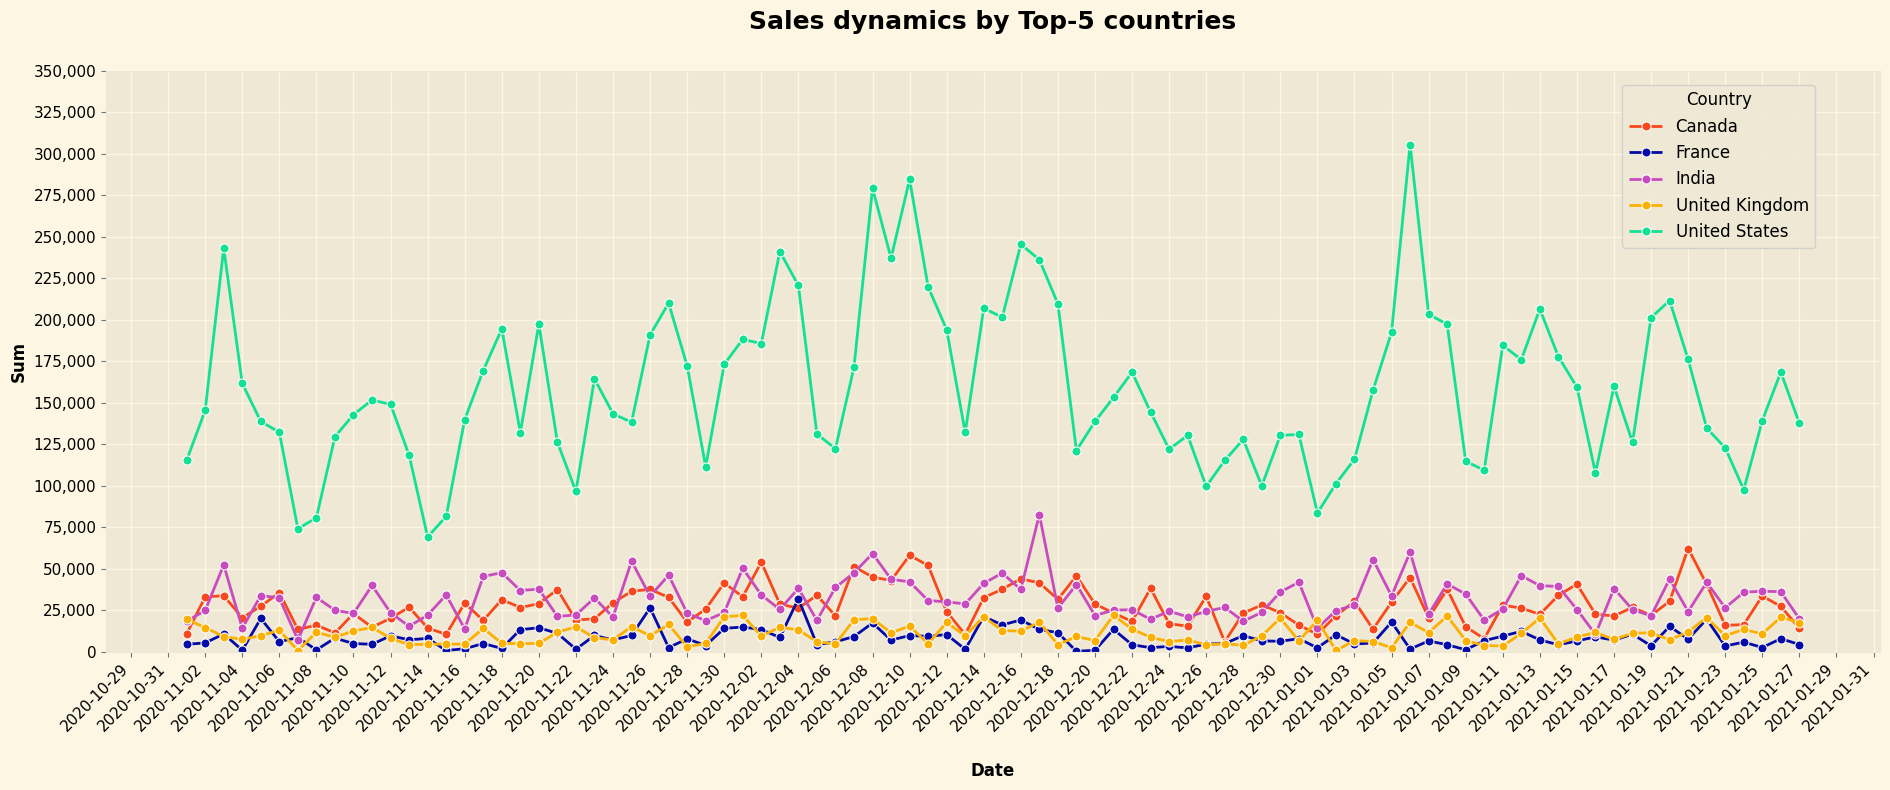

In [ ]:
# Встановлення стилю
plt.style.use('Solarize_Light2')
colors_13 =  ['#f8481c', '#030aa7', '#c94cbe', '#fcb001', '#12e193']

# Створення фігури
plt.figure(figsize=(19, 8))

# Створення графіка для 'total_daily_revenue'
sns.lineplot(
    data=top_5_countries_sales_dynamics,
    x='session_date',
    y='total_sales_sum',
    hue='country',
    marker='o',
    markersize=6.5,
    palette = colors_13
)


# Додавання заголовків та підписів
plt.title('Sales dynamics by Top-5 countries', fontsize=18, fontweight='bold', pad=30)
plt.xlabel('Date', fontsize=12, fontweight='bold', color='black', labelpad=20)
plt.ylabel('Sum', fontsize=12, fontweight='bold', color='black')
plt.xticks(rotation=45, ha='right', fontsize=11, color='black')
plt.yticks(fontsize=11, color='black')

# Налаштування міток осей. Використовуємо Locator, щоб відображати кожну n мітку,
ax13 = plt.gca() #функція повертає об'єкт осей (Axes), на який зараз налаштована робота Matplotlib
ax13.xaxis.set_major_locator(ticker.MultipleLocator(2))
# Налаштування формату осі Y
ax13.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax13.yaxis.set_major_locator(ticker.MultipleLocator(25000))

plt.ylim(0, 350000)

# Відображення легенди
plt.legend(title='Country', bbox_to_anchor=(0.85, 0.99), loc='upper left', fontsize=12, title_fontsize=12)


plt.tight_layout()
plt.show()

The **USA** stands out significantly in terms of revenue level. The countries in **2nd, 3rd, 4th, and 5th** place have a relatively similar revenue level and comparable dynamics, with different fluctuations on various days but generally remaining stable. In the USA, the most profitable days were **January 6, December 8, and December 10**.

----

**США** значно виділяються за рівнем доходу. Країни, що посідають **2, 3, 4** та **5** місця за доходом, мають приблизно однаковий рівень і схожу динаміку, з різними коливаннями в окремі дні, але в цілому стабільними. У США найбільш прибутковими днями були **6 січня, 8 та 10 грудня**.

### **Sales dynamics by traffic channel**

In [ ]:
# Групуємо за типом користувача та датою
sales_by_channel_and_date = company_data[(company_data['total_daily_revenue'].notna()) & (company_data['traffic_channel'] != 'Unknown Channel')].groupby(['session_date', 'traffic_channel'])['product_price'].sum().reset_index().rename(columns={"product_price": "total_sales_sum"})

print("Sales by traffic channel and date")
sales_by_channel_and_date

Sales by traffic channel and date


,session_date,traffic_channel,total_sales_sum
0,2020-11-01,Direct,54669.5
1,2020-11-01,Organic Search,95112.0
2,2020-11-01,Paid Search,64688.0
3,2020-11-01,Social Search,25078.0
4,2020-11-02,Direct,81561.5
...,...,...,...
347,2021-01-26,Social Search,17008.0
348,2021-01-27,Direct,70423.1
349,2021-01-27,Organic Search,92921.1
350,2021-01-27,Paid Search,80869.5


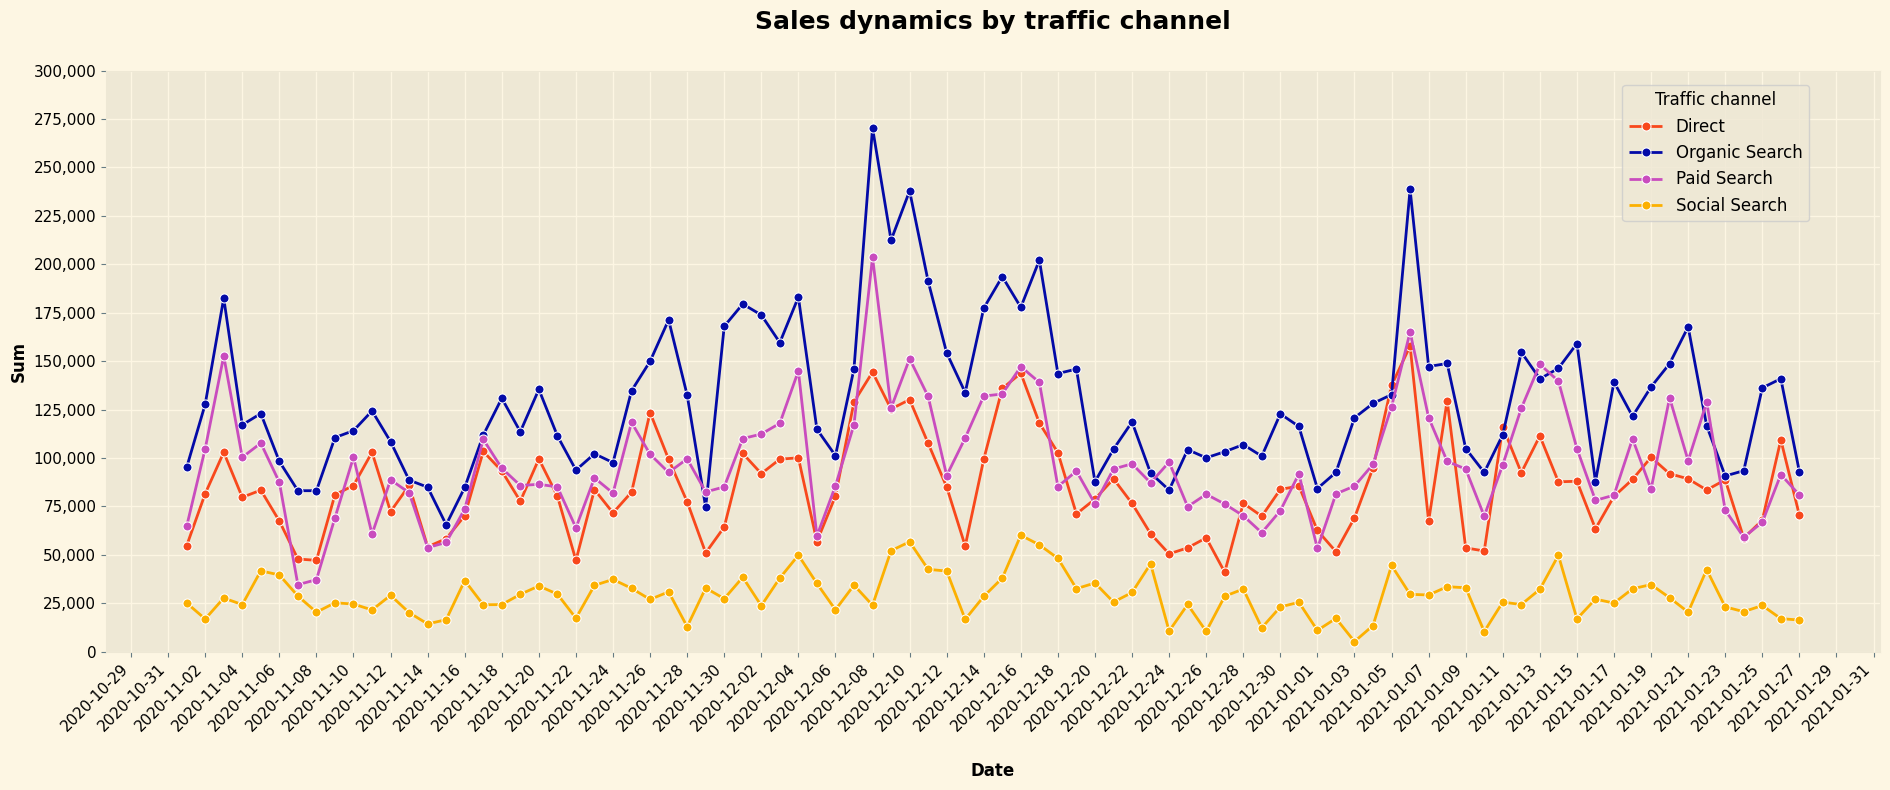

In [ ]:
# Встановлення стилю
plt.style.use('Solarize_Light2')
colors_14 =  ['#f8481c', '#030aa7', '#c94cbe', '#fcb001']

# Створення фігури
plt.figure(figsize=(19, 8))

# Створення графіка для 'total_daily_revenue'
sns.lineplot(
    data=sales_by_channel_and_date,
    x='session_date',
    y='total_sales_sum',
    hue='traffic_channel',
    marker='o',
    markersize=6.5,
    palette = colors_14
)


# Додавання заголовків та підписів
plt.title('Sales dynamics by traffic channel', fontsize=18, fontweight='bold', pad=30)
plt.xlabel('Date', fontsize=12, fontweight='bold', color='black', labelpad=20)
plt.ylabel('Sum', fontsize=12, fontweight='bold', color='black')
plt.xticks(rotation=45, ha='right', fontsize=11, color='black')
plt.yticks(fontsize=11, color='black')

# Налаштування міток осей. Використовуємо Locator, щоб відображати кожну n мітку,
ax14 = plt.gca() #функція повертає об'єкт осей (Axes), на який зараз налаштована робота Matplotlib
ax14.xaxis.set_major_locator(ticker.MultipleLocator(2))
# Налаштування формату осі Y
ax14.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax14.yaxis.set_major_locator(ticker.MultipleLocator(25000))

plt.ylim(0, 300000)

# Відображення легенди
plt.legend(title='Traffic channel', bbox_to_anchor=(0.85, 0.99), loc='upper left', fontsize=12, title_fontsize=12)


plt.tight_layout()
plt.show()

All traffic channels show a similar dynamic, with peaks and dips occurring during the same periods, indicating they operate at a stable pace. **Organic Search** maintains a dominant position throughout the entire period. **Social Search** is consistently the channel with the lowest revenue. **Direct** and **Paid Search** hold a middle position, crossing over and trading places in dominance and decline.

***

Усі канали трафіку демонструють схожу динаміку, з піками та спадами, що відбуваються в один і той же період, що свідчить про їх стабільну роботу. **Organic Search** зберігає домінуючу позицію протягом усього часу. **Social Search** постійно є каналом з найменшим доходом. **Direct** та **Paid Search** займають проміжне положення, перетинаючись та міняючись місцями за домінуванням і спадом.

# **Statistical analysis**

## **Correlation analysis**

### **Number of sessions and total sales for each date**

Let's filter the data for the last few days where there were no sales, as this is most likely due to data incompleteness rather than a real absence of sales. Including them would distort the actual data distribution.

---

Відфільтруємо дані за останні дні, коли немає продажів, адже це, швидше за все, виникло через неповноту даних, а не через реальну відсутність продажів. Їх включення буде спотворювати реальний розподіл даних.

In [ ]:
# Групуємо дані за датою та агрегуємо сесії і продажі
daily_sessions_and_sales = company_data[company_data['total_daily_revenue'].notna()].groupby('session_date').agg(total_sessions=('session_id', 'count'), total_sales=('product_price', 'sum'))

daily_sessions_and_sales

,total_sessions,total_sales
session_date,,
2020-11-01,2576,244292.5
2020-11-02,3599,355506.8
2020-11-03,5173,498979.6
2020-11-04,4184,339187.1
2020-11-05,3743,391276.6
...,...,...
2021-01-23,3067,290605.5
2021-01-24,2893,243818.4
2021-01-25,3760,305089.3


Let's check the normality of the distribution. Since our sample size is greater than 50, we can use the **D'Agostino-Pearson test**.

---

Перевіримо нормальність розподілу. Оскільки ми маємо вибірку >50 значень, то можемо використати **тест Д'Агостіно-Пірсона**.

Normaltest for total_sessions p-value: 0.014530886606437964
Normaltest for total_sales p-value: 0.007155898618108501



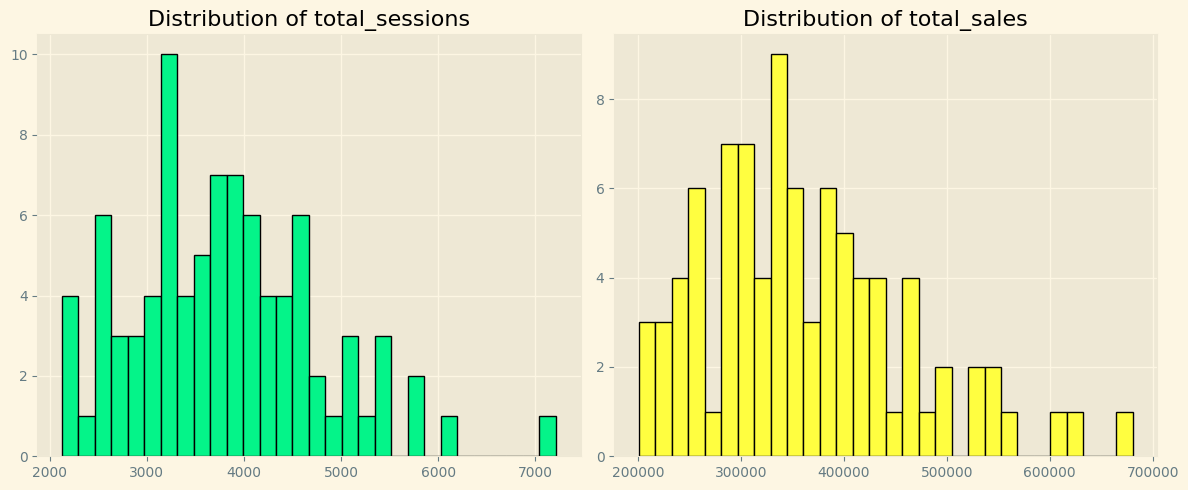

In [ ]:
# Normaltest
_, p_value_normaltest_normal_total_sessions = stats.normaltest(daily_sessions_and_sales['total_sessions'])
_, p_value_normaltest_normal_total_sales = stats.normaltest(daily_sessions_and_sales['total_sales'])

# Test results
print(f"Normaltest for total_sessions p-value: {p_value_normaltest_normal_total_sessions}")
print(f"Normaltest for total_sales p-value: {p_value_normaltest_normal_total_sales}\n")

# Plotting histograms to visualize data distributions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(daily_sessions_and_sales['total_sessions'], bins=30, color="#04f489", edgecolor="black")
plt.title("Distribution of total_sessions")

plt.subplot(1, 2, 2)
plt.hist(daily_sessions_and_sales['total_sales'], bins=30, color="#fffe40", edgecolor="black")
plt.title("Distribution of total_sales")


plt.tight_layout()
plt.show()

Both histograms show a slight positive skew (right tail), but overall the distribution is similar to normal. The **p-value** from the D'Agostino-Pearson test is less than **0.05** for both samples. However, for samples >50, the D'Agostino-Pearson test is very sensitive (as is the Shapiro-Wilk test) and often rejects the null hypothesis even with minor deviations from normality.

Since the histograms demonstrate a distribution that is sufficiently close to normal, we will use the **Pearson correlation coefficient** for correlation analysis. It is robust to minor deviations from normality, especially with a large sample, and will give the most accurate estimate of the linear relationship, which we will also verify graphically.

---

На обох гістограмах спостерігається невелика асиметрія з правим хвостом, але в цілому розподіл схожий на нормальний. **p-value** за тестом Д'Агостіно-Пірсона менше за **0.05** для обох вибірок. Однак для вибірок >50 тест Д'Агостіно-Пірсона є дуже чутливим (як і тест Шапіро-Вілка) і часто відхиляє нульову гіпотезу навіть при незначних відхиленнях від нормальності.

Оскільки гістограми демонструють розподіл, який є достатньо близьким до нормального, використаємо **коефіцієнт кореляції Пірсона** для аналізу кореляції. Він є стійким до незначних відхилень від нормальності, особливо коли вибірка велика, і дасть найточнішу оцінку лінійного зв'язку, яку ми також перевіримо графічно.

In [ ]:
pearson_sessions_sales, p_value_sessions_sales = stats.pearsonr(daily_sessions_and_sales['total_sessions'], daily_sessions_and_sales['total_sales'])
print(f"Pearson p-value for number of sessions and total sales: {p_value_sessions_sales}")
print(f"Pearson correlation coefficient for number of sessions and total sales: {pearson_sessions_sales}")

Pearson p-value for number of sessions and total sales: 1.7394621412998283e-39
Pearson correlation coefficient for number of sessions and total sales: 0.9313146607045041


A correlation coefficient of **0.93** indicates a very high positive relationship, and the p-value, being significantly less than **0.05**, shows that this correlation coefficient is statistically significant. Therefore, we can accept the alternative hypothesis **H1** that **there is a direct linear relationship between the number of sessions and the level of sales**.

---

Коефіцієнт кореляції **0.93** свідчить про наявність дуже високого позитивного зв'язку, а **p-value**, значно менше за **0.05**, вказує на статистичну значущість цього коефіцієнта. Отже, ми можемо прийняти альтернативну гіпотезу **H1** про те, що **існує пряма лінійна залежність між кількістю сесій та рівнем продажів.**

Let's also build a scatter plot to visualize the relationship.

***
Побудуємо також точкову діаграму для візуалізації взаємозв’язку.

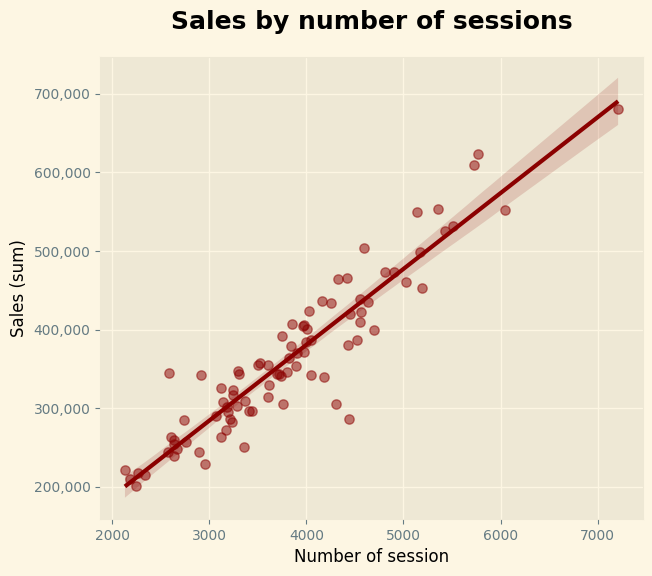

In [ ]:
plt.figure(figsize=(7, 6))

ax15 = sns.regplot(data=daily_sessions_and_sales, x="total_sessions", y="total_sales", fit_reg=True, color="darkred", scatter_kws={"alpha": 0.5, "s": 45})

plt.title("Sales by number of sessions", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Number of session", fontsize=12, color = "black")
plt.ylabel("Sales (sum)", fontsize=12, color = "black")

#ax15.yaxis.set_major_locator(ticker.MultipleLocator(800000))
ax15.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

The points on the graph are clustered **tightly around the regression line**, although there are a couple of **outliers**. This indicates a **high correlation**, as there is no significant data scatter. The closer the points are to the line, the **stronger the relationship**.

The regression line has a **positive slope** (it goes **up from left to right**), confirming a **direct relationship**: as the number of sessions increases, the line predicts an increase in sales.

The shaded area around the regression line shows the **confidence interval**. The **narrow interval** indicates **high predictive accuracy**, which further confirms the **strong relationship** between the two variables.

Thus, the graph visually **confirms the conclusions of the statistical analysis** that the number of sessions is **closely related to the level of sales**.

---

Точки на графіку розташовані **щільно навколо лінії регресії**, хоча і є кілька **викидів**. Це вказує на **високу кореляцію**, оскільки немає значного розсіювання даних. Чим ближче точки до лінії, тим **сильніший зв'язок**.

Лінія регресії має **позитивний нахил** (іде **вгору зліва направо**), що підтверджує **пряму залежність**: коли кількість сесій збільшується, лінія прогнозує **зростання продажів**.

Затінена область навколо лінії регресії показує **довірчий інтервал**. **Вузький інтервал** свідчить про **високу точність прогнозу**, що ще раз підтверджує **сильний зв'язок** між двома змінними.

Таким чином, візуально графік **підтверджує висновки статистичного аналізу**, що кількість сесій **тісно пов'язана з рівнем продажів**.

### **Is the expected revenue correlated with the actual revenue?**

In [ ]:
# ми вже маємо змінну sales_dynamics яка мість реальні продажі та очікуваний дохід за кожну дату
sales_dynamics

,session_date,daily_revenue_predict,total_daily_revenue
0,2020-11-01,351952.020,244292.5
1,2020-11-02,547192.038,355506.8
2,2020-11-03,737844.352,498979.6
3,2020-11-04,472059.162,339187.1
4,2020-11-05,574365.168,391276.6
...,...,...,...
83,2021-01-23,418842.855,290605.5
84,2021-01-24,365542.291,243818.4
85,2021-01-25,442304.081,305089.3
86,2021-01-26,569533.230,372057.3


Let's check the normality of the distribution. Since our sample size is greater than 50, we can use the **D'Agostino-Pearson test**.

---

Перевіримо нормальність розподілу. Оскільки ми маємо вибірку >50 значень, то можемо використати **тест Д'Агостіно-Пірсона**.

Normaltest for daily_revenue_predict p-value: 0.024826807529138146
Normaltest for total_daily_revenue p-value: 0.007155898618108501



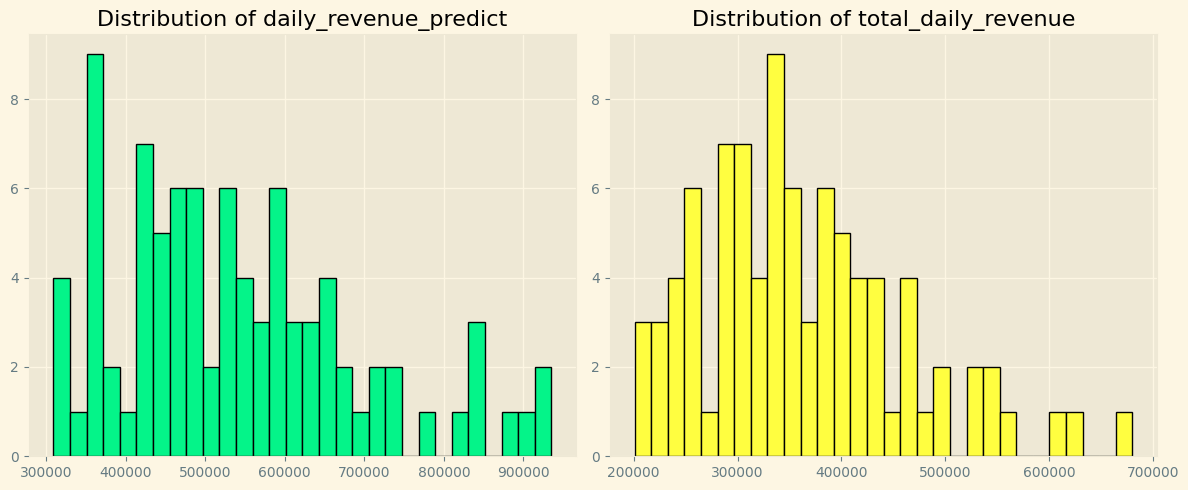

In [ ]:
# Normaltest
_, p_value_normaltest_daily_revenue_predict = stats.normaltest(sales_dynamics['daily_revenue_predict'])
_, p_value_normaltest_total_daily_revenue = stats.normaltest(sales_dynamics['total_daily_revenue'])

# Test results
print(f"Normaltest for daily_revenue_predict p-value: {p_value_normaltest_daily_revenue_predict}")
print(f"Normaltest for total_daily_revenue p-value: {p_value_normaltest_total_daily_revenue}\n")

# Plotting histograms to visualize data distributions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(sales_dynamics['daily_revenue_predict'], bins=30, color="#04f489", edgecolor="black")
plt.title("Distribution of daily_revenue_predict")

plt.subplot(1, 2, 2)
plt.hist(sales_dynamics['total_daily_revenue'], bins=30, color="#fffe40", edgecolor="black")
plt.title("Distribution of total_daily_revenue")


plt.tight_layout()
plt.show()

Here, both histograms also show a slight **positive skew** (right tail), and the **p-value** is also less than **0.05** in both samples. But just like in the previous case, it is still appropriate to use the **Pearson correlation coefficient** for correlation analysis.

***
Тут на обох гістограмах також спостерігається невелика **асиметрія з правим хвостом**, а **p-value** також менше за **0.05** в обох вибірках. Але, як і в попередньому випадку, все одно доцільно використовувати **коефіцієнт кореляції Пірсона** для аналізу кореляції.

In [ ]:
pearson_revenue, p_value_revenue = stats.pearsonr(sales_dynamics['daily_revenue_predict'], sales_dynamics['total_daily_revenue'])
print(f"Pearson p-value for revenue: {p_value_revenue}")
print(f"Pearson correlation coefficient for revenue: {pearson_revenue}")

Pearson p-value for revenue: 2.991667118058501e-58
Pearson correlation coefficient for revenue: 0.9753886088894987


The correlation coefficient is **0.98**, and the **p-value** is significantly less than **0.05**, which confirms the statistical significance of the correlation coefficient. We accept the alternative hypothesis **H1** that **there is a direct linear relationship between the level of forecasted revenue and actual sales.**

---

Коефіцієнт кореляції становить **0.98**, а **p-value** значно менше за **0.05**, що підтверджує статистичну значущість коефіцієнта кореляції. Приймаємо альтернативну гіпотезу **H1** про те, що **існує пряма лінійна залежність між рівнем прогнозованого доходу та реальними продажами**.

Let's also build a scatter plot to visualize the relationship.

***
Побудуємо також точкову діаграму для візуалізації взаємозв’язку.

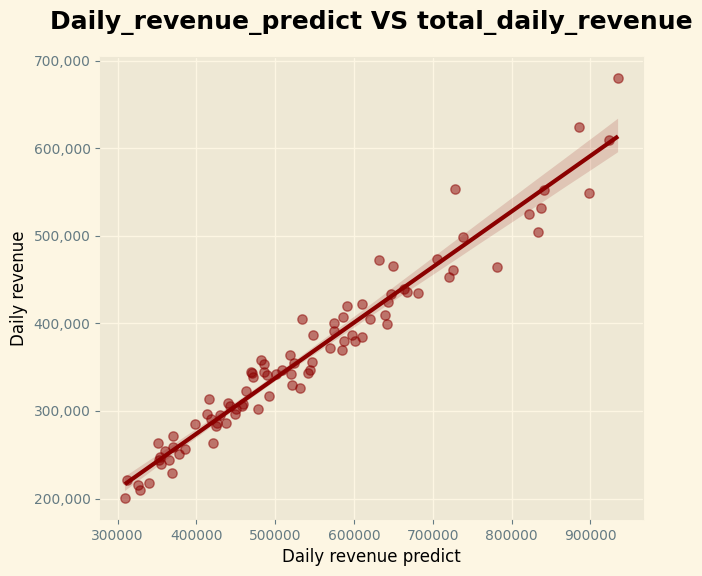

In [ ]:
plt.figure(figsize=(7, 6))

ax16 = sns.regplot(data=sales_dynamics, x="daily_revenue_predict", y="total_daily_revenue", fit_reg=True, color="darkred", scatter_kws={"alpha": 0.5, "s": 45})

plt.title("Daily_revenue_predict VS total_daily_revenue", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Daily revenue predict", fontsize=12, color = "black")
plt.ylabel("Daily revenue", fontsize=12, color = "black")

#ax15.yaxis.set_major_locator(ticker.MultipleLocator(800000))
ax16.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

The scatter plot indicates a **strong positive relationship** between the forecasted and actual revenue.

---

Точкова діаграма вказує на наявність **сильного позитивного зв'язку** між прогнозованим та реальним доходом.

### **Do sales from different traffic channels correlate with each other?**

Let's calculate this using a correlation matrix

---

Розрахуємо це за допомогою матриці кореляцій

In [ ]:
sales_by_channel_for_corr = company_data[(company_data['traffic_channel'] != "Unknown Channel") & (company_data["total_daily_revenue"].notna())].pivot_table(index='session_date', columns='traffic_channel', values='product_price', aggfunc='sum')
sales_by_channel_for_corr


traffic_channel,Direct,Organic Search,Paid Search,Social Search
session_date,,,,
2020-11-01,54669.5,95112.0,64688.0,25078.0
2020-11-02,81561.5,127746.5,104780.8,16843.0
2020-11-03,102909.5,182521.9,152641.3,27652.5
2020-11-04,79683.6,117067.1,100332.0,24257.4
2020-11-05,83367.6,122938.4,107648.0,41693.2
...,...,...,...,...
2021-01-23,88714.4,90686.0,73075.1,23095.0
2021-01-24,58644.2,93413.6,59018.0,20596.1
2021-01-25,67844.0,136178.6,66775.7,23809.0


In [ ]:
# Розраховуємо матрицю кореляції
correlation_matrix_channel = sales_by_channel_for_corr.corr()

correlation_matrix_channel

traffic_channel,Direct,Organic Search,Paid Search,Social Search
traffic_channel,,,,
Direct,1.000000,0.759938,0.724343,0.461895
Organic Search,0.759938,1.000000,0.808234,0.434424
Paid Search,0.724343,0.808234,1.000000,0.452287
Social Search,0.461895,0.434424,0.452287,1.000000


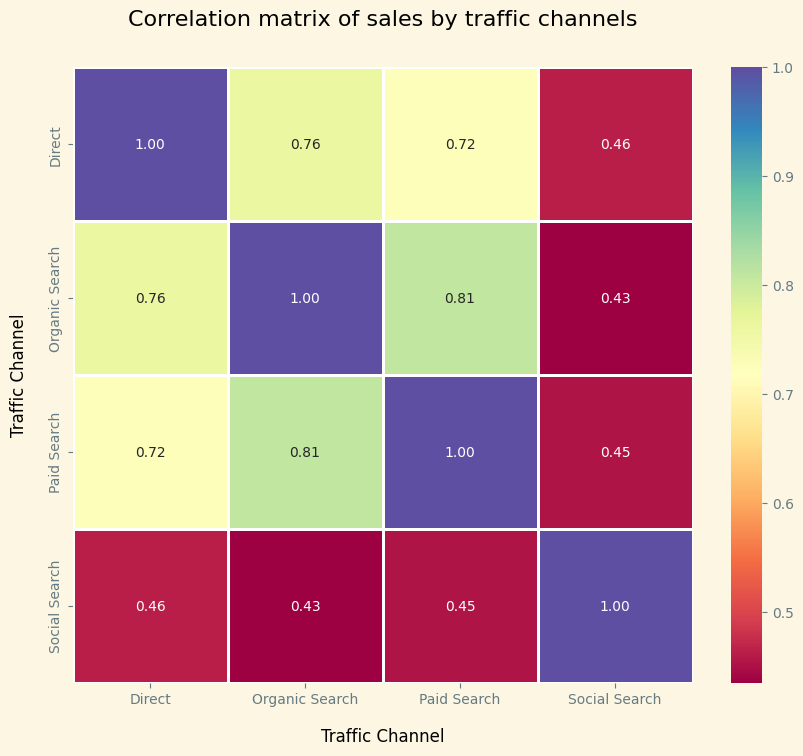

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix_channel, #таблиця
    annot=True,# показує значення коефіцієнтів на карті
    cmap='Spectral', # кольорова палітра
    fmt=".2f", # формат чисел
    linewidths=0.9 # ширина рзділювальних лінії між клітинками
)

# Додавання підписів осей
plt.xlabel('Traffic Channel', fontsize=12, labelpad=15, color = 'black')
plt.ylabel('Traffic Channel', fontsize=12, labelpad=15, color = 'black')
plt.title('Correlation matrix of sales by traffic channels', fontsize=16, pad=30)

plt.show()

The following pairs of traffic channels have sufficiently high correlation coefficients and correlate with each other:
* Organic Search vs. Direct
* Paid Search vs. Direct
* Organic Search vs. Paid Search

This might be related to the fact that these are the most popular traffic channels.

***

Мають достатньо високі коефіцієнти кореляції та корелюють між собою такі пари каналів трафіку:
* Organic Search VS Direct;
* Paid Search VS Direct;
* Organic Search VS Paid Search.

Це може бути пов'язано з тим, що це найпопулярніші канали трафіку.

## **Statistical analysis of group differences**

### **Comparing sales between registered and unregistered users**

In [ ]:
# вже маємо таблиці продаж по типа корситувачів
sales_by_user_type_and_date

,session_date,user_type,total_sales_sum
0,2020-11-01,Registered user,21547.0
1,2020-11-01,Unregistered user,222745.5
2,2020-11-02,Registered user,44956.8
3,2020-11-02,Unregistered user,310550.0
4,2020-11-03,Registered user,29150.5
...,...,...,...
171,2021-01-25,Unregistered user,270925.5
172,2021-01-26,Registered user,27213.6
173,2021-01-26,Unregistered user,344843.7
174,2021-01-27,Registered user,14613.6


In [ ]:
#перетворимо таблицю на широкий формат для падальших розрахунків
wide_sales_by_user_type_and_date = sales_by_user_type_and_date.pivot_table(index='session_date', columns='user_type', values='total_sales_sum')
wide_sales_by_user_type_and_date

user_type,Registered user,Unregistered user
session_date,,
2020-11-01,21547.0,222745.5
2020-11-02,44956.8,310550.0
2020-11-03,29150.5,469829.1
2020-11-04,20982.2,318204.9
2020-11-05,25334.6,365942.0
...,...,...
2021-01-23,16117.0,274488.5
2021-01-24,20914.0,222904.4
2021-01-25,34163.8,270925.5


Let's check the normality of the distribution. Since our sample size is greater than 50, we can use the **D'Agostino-Pearson test**.

---

Перевіримо нормальність розподілу. Оскільки ми маємо вибірку >50 значень, то можемо використати **тест Д'Агостіно-Пірсона**

Normaltest for Registered user p-value: 0.010929121653065912
Normaltest for Unregistered user p-value: 0.005566190512660351



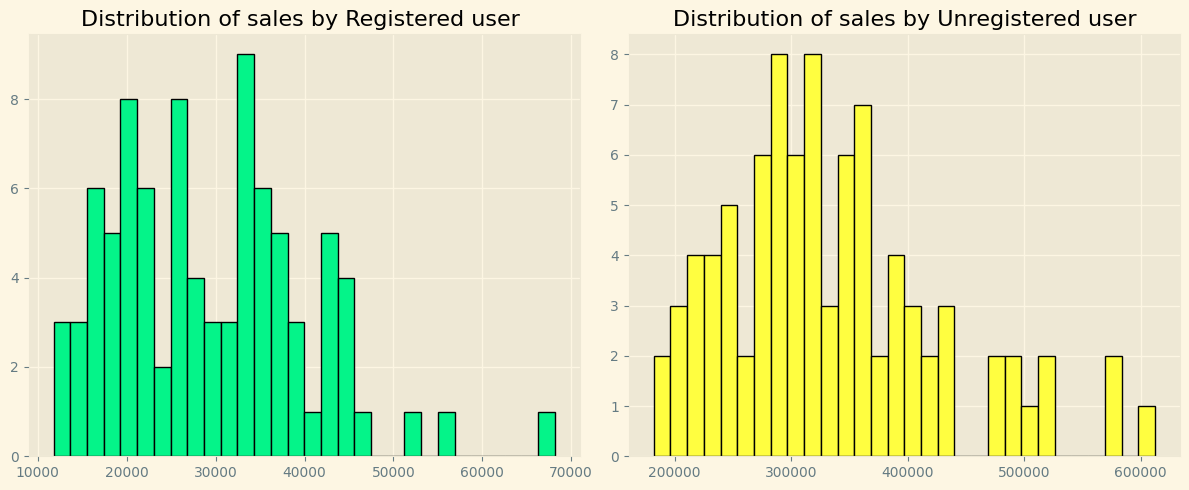

In [ ]:
# Normaltest
_, p_value_normaltest_Registered_user = stats.normaltest(wide_sales_by_user_type_and_date['Registered user'])
_, p_value_normaltest_Unregistered_user = stats.normaltest(wide_sales_by_user_type_and_date['Unregistered user'])

# Test results
print(f"Normaltest for Registered user p-value: {p_value_normaltest_Registered_user}")
print(f"Normaltest for Unregistered user p-value: {p_value_normaltest_Unregistered_user}\n")

# Plotting histograms to visualize data distributions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(wide_sales_by_user_type_and_date['Registered user'], bins=30, color="#04f489", edgecolor="black")
plt.title("Distribution of sales by Registered user ")

plt.subplot(1, 2, 2)
plt.hist(wide_sales_by_user_type_and_date['Unregistered user'], bins=30, color="#fffe40", edgecolor="black")
plt.title("Distribution of sales by Unregistered user")


plt.tight_layout()
plt.show()

Normaltest for Registered user p-value: 0.010

Normaltest for Unregistered user p-value: 0.006

---

Since the **p-value** in both samples is significantly less than **0.05**, their distributions should be considered non-normal. To test for a difference between these samples, it is better to use the **non-parametric Mann-Whitney U-test**, which compares the medians of two independent samples to determine if there is a statistically significant difference between their distributions.

---

Оскільки в обох вибірках **p-value** значно менше за **0.05**, розподіл у них варто вважати ненормальним. Для перевірки різниці між цими вибірками краще використати **непараметричний U-тест Манна-Вітні**, який порівнює медіани двох незалежних вибірок, щоб визначити, чи існує статистично значуща різниця між їхніми розподілами.

In [ ]:
_, p_value_mannwhitneyu_user_type = stats.mannwhitneyu(wide_sales_by_user_type_and_date['Registered user'], wide_sales_by_user_type_and_date['Unregistered user'])


median_Registered_user = wide_sales_by_user_type_and_date['Registered user'].median()
median_Unregistered_user = wide_sales_by_user_type_and_date['Unregistered user'].median()

print(f"U-statistic for user type p-value: {p_value_mannwhitneyu_user_type}")
print(f"median sales of Registered_user: {median_Registered_user}")
print(f"median sales of Unregistered_user: {median_Unregistered_user}")

U-statistic for user type p-value: 2.2159276950123465e-30
median sales of Registered_user: 28048.0
median sales of Unregistered_user: 316724.25


The p-value obtained from the **Mann-Whitney U-test** is significantly less than **0.05**, which indicates a statistically significant difference between the samples. Since the **median sales for unregistered users is higher**, we can accept the alternative hypothesis that **unregistered users buy more than registered users**.

***

Отриманий за допомогою **U-тесту Манна-Вітні** **p-value** значно менший за **0.05**, що свідчить про статистичну значущість відмінності між вибірками. Оскільки **медіана продажів серед незареєстрованих користувачів вища**, ми можемо прийняти альтернативну гіпотезу про те, що **незареєстровані користувачі купують більше, ніж зареєстровані**.

### **Differences between sales by different categories**

In [ ]:
#відфільтруємо топ 5 каотегорій та сформуємо таблицю
top_5_categories = company_data.groupby('product_category')['product_price'].sum().nlargest(5).index
top_5_categories_df = company_data[company_data['product_category'].isin(top_5_categories)][['session_date', 'product_category', 'product_price']]

top_5_categories_sales = pd.pivot_table(top_5_categories_df, values="product_price", index='session_date', columns="product_category", aggfunc="sum").sort_values(by = "session_date", ascending = True).rename(columns={"product_price": "total_sales_sum"})

print('Sales by Top-5 product categories:')
top_5_categories_sales

Sales by Top-5 product categories:


product_category,Beds,Bookcases & shelving units,Cabinets & cupboards,Chairs,Sofas & armchairs
session_date,,,,,
2020-11-01,14041.0,36701.0,13591.5,46006.0,75216.0
2020-11-02,79683.5,40979.0,21623.0,58834.0,79977.5
2020-11-03,66219.5,64360.1,33555.5,61204.0,175594.0
2020-11-04,48939.0,35719.8,19266.0,44113.0,86861.5
2020-11-05,23449.0,40998.8,29235.0,90388.4,137288.0
...,...,...,...,...,...
2021-01-23,37116.0,29862.7,26068.0,57493.0,76898.0
2021-01-24,23294.0,25396.0,23664.5,54288.0,57837.0
2021-01-25,47303.5,25919.6,33028.0,51424.2,84544.0



Let's check the data for normality of distribution.

---

Перевіримо дані на нормальність розподілу.

Normaltest for Beds p-value: 2.1452760355452934e-05
Normaltest for Bookcases p-value: 0.015258119024676019
Normaltest for Cabinets p-value: 0.0006516690890353964
Normaltest for Chairs p-value: 0.001152458339643346
Normaltest for Sofas p-value: 0.015090890148769022



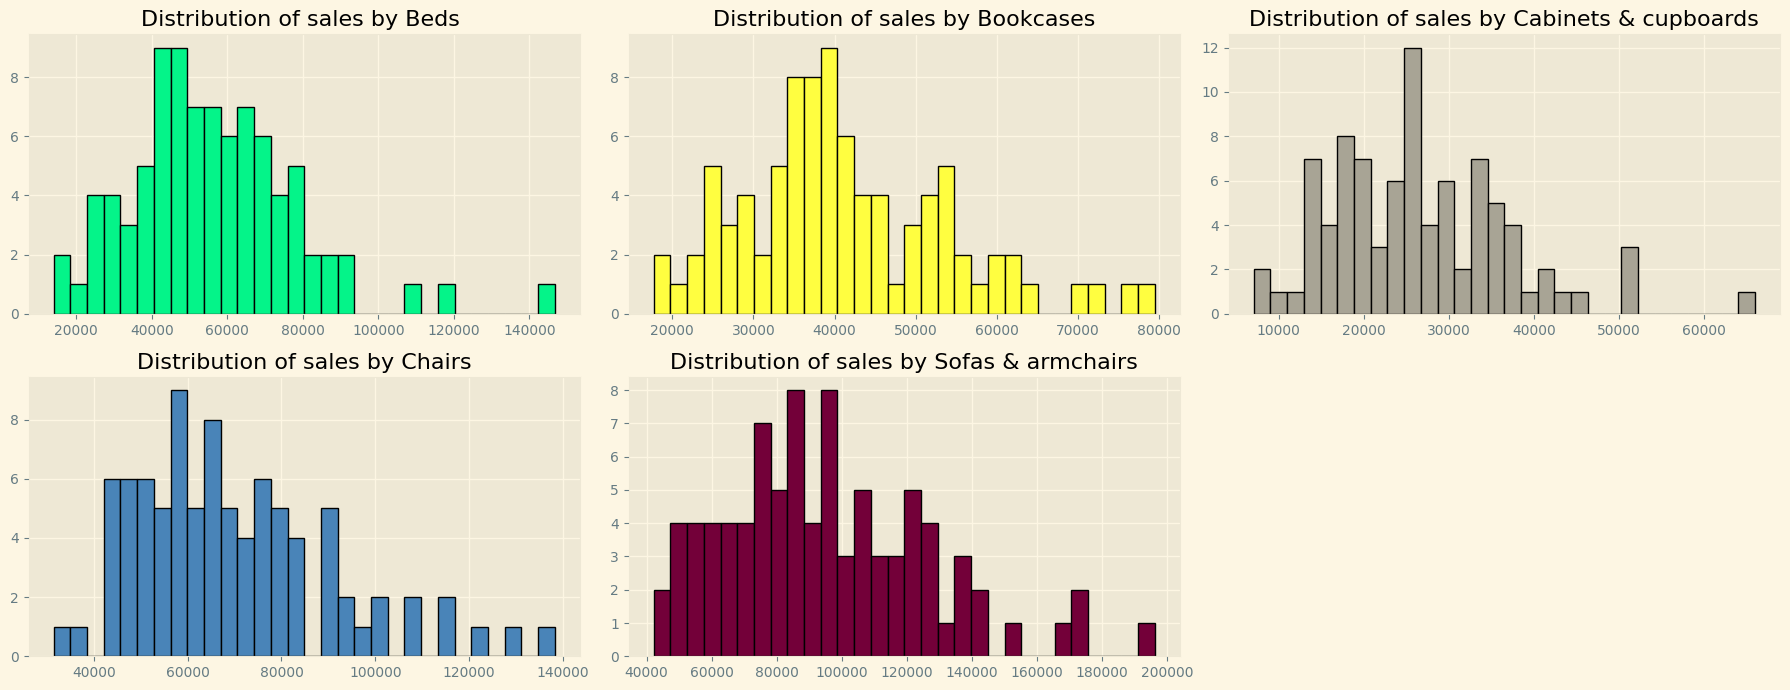

In [ ]:
# Normaltest
_, p_value_normaltest_Beds = stats.normaltest(top_5_categories_sales['Beds'])
_, p_value_normaltest_Bookcases = stats.normaltest(top_5_categories_sales['Bookcases & shelving units'])
_, p_value_normaltest_Cabinets = stats.normaltest(top_5_categories_sales['Cabinets & cupboards'])
_, p_value_normaltest_Chairs = stats.normaltest(top_5_categories_sales['Chairs'])
_, p_value_normaltest_Sofas = stats.normaltest(top_5_categories_sales['Sofas & armchairs'])

# Test results
print(f"Normaltest for Beds p-value: {p_value_normaltest_Beds}")
print(f"Normaltest for Bookcases p-value: {p_value_normaltest_Bookcases}")
print(f"Normaltest for Cabinets p-value: {p_value_normaltest_Cabinets}")
print(f"Normaltest for Chairs p-value: {p_value_normaltest_Chairs}")
print(f"Normaltest for Sofas p-value: {p_value_normaltest_Sofas}\n")

# Plotting histograms to visualize data distributions
plt.figure(figsize=(18, 7))
plt.subplot(2, 3, 1)
plt.hist(top_5_categories_sales['Beds'], bins=30, color="#04f489", edgecolor="black")
plt.title("Distribution of sales by Beds ")

plt.subplot(2, 3, 2)
plt.hist(top_5_categories_sales['Bookcases & shelving units'], bins=30, color="#fffe40", edgecolor="black")
plt.title("Distribution of sales by Bookcases")

plt.subplot(2, 3, 3)
plt.hist(top_5_categories_sales['Cabinets & cupboards'], bins=30, color="#a8a495", edgecolor="black")
plt.title("Distribution of sales by Cabinets & cupboards")

plt.subplot(2, 3, 4)
plt.hist(top_5_categories_sales['Chairs'], bins=30, color="#4984b8", edgecolor="black")
plt.title("Distribution of sales by Chairs")

plt.subplot(2, 3, 5)
plt.hist(top_5_categories_sales['Sofas & armchairs'], bins=30, color="#730039", edgecolor="black")
plt.title("Distribution of sales by Sofas & armchairs")



plt.tight_layout()
plt.show()

The distribution in all samples is not normal (p-value is less than 0.05). Therefore, to compare several samples at once, we will use the **Kruskal-Wallis test** (a non-parametric analogue of ANOVA).

---
Розподіл у всіх вибірках не відповідає нормальному (**p-value** менше за **0.05**). Тому для порівняння кількох вибірок одразу використаємо **тест Крускала-Уолліса** (непараметричний аналог ANOVA).

In [ ]:
_, p_value_kruska_category = stats.kruskal(top_5_categories_sales['Beds'], top_5_categories_sales['Bookcases & shelving units'], top_5_categories_sales['Cabinets & cupboards'], top_5_categories_sales['Chairs'], top_5_categories_sales['Sofas & armchairs'])

beds_median = top_5_categories_sales['Beds'].median()
bookcases_median = top_5_categories_sales['Bookcases & shelving units'].median()
cabinets_median = top_5_categories_sales['Cabinets & cupboards'].median()
chairs_median = top_5_categories_sales['Chairs'].median()
sofas_median = top_5_categories_sales['Sofas & armchairs'].median()

print(f"Beds Median: {beds_median:.2f}")
print(f"Bookcases & shelving units Median: {bookcases_median:.2f}")
print(f"Cabinets & cupboards Median: {cabinets_median:.2f}")
print(f"Chairs Median: {chairs_median:.2f}")
print(f"Sofas & armchairs Median: {sofas_median:.2f}\n")

print(f"Kruskal-Wallis test by categories p-value: {p_value_kruska_category}")

Beds Median: 53629.25
Bookcases & shelving units Median: 38906.90
Cabinets & cupboards Median: 25225.00
Chairs Median: 66242.70
Sofas & armchairs Median: 92103.00

Kruskal-Wallis test by categories p-value: 5.651601684267439e-59


The **p-value** obtained from the **Kruskal-Wallis test**, which is less than **0.05**, indicates that the differences in total sales among the top 5 categories are **statistically significant**. Therefore, we can accept the alternative hypothesis that the categories differ from each other in total sales. **By comparing the median values of each category**, they are ranked from most to least profitable as follows:

1.  **Sofas & armchairs**
2.  **Chairs**
3.  **Beds**
4.  **Cabinets & cupboards**
5.  **Bookcases & shelving units**

***

Отриманий за допомогою **тесту Крускала-Уолліса p-value**, який менший за **0.05**, свідчить про те, що відмінності в сумі продажів по топ 5 категоріях є **статистично значущими**. Тому ми можемо прийняти альтернативну гіпотезу про те, що категорії відрізняються між собою за сумою продажів. **Порівнявши медіанні значення кожної категорії**,можна сказати, що вони мають такий розподіл від найбільш прибуткової за зниженням прибутку:

1.  **Sofas & armchairs**
2.  **Chairs**
3.  **Beds**
4.  **Cabinets & cupboards**
5.  **Bookcases & shelving units**

### **Statistical difference in the number of sessions by various traffic channels**

In [ ]:
sessions_by_channel = company_data[(company_data['traffic_channel'] != "Unknown Channel")].pivot_table(index='session_date', columns='traffic_channel', values='session_id', aggfunc='count')
sessions_by_channel

traffic_channel,Direct,Organic Search,Paid Search,Social Search
session_date,,,,
2020-11-01,608,920,706,214
2020-11-02,810,1242,970,315
2020-11-03,1216,1871,1367,392
2020-11-04,935,1425,1145,368
2020-11-05,845,1293,917,346
...,...,...,...,...
2021-01-27,984,1561,1192,359
2021-01-28,997,1379,1107,364
2021-01-29,878,1319,988,288



Let's check the data for normality of distribution.

---

Перевіримо дані на нормальність розподілу.

Normaltest for Direct p-value: 0.007853358264896217
Normaltest for Organic search p-value: 0.0031046084804515037
Normaltest for Paid Search p-value: 0.0016504167955096551
Normaltest for Social Search p-value: 0.21439918696878835



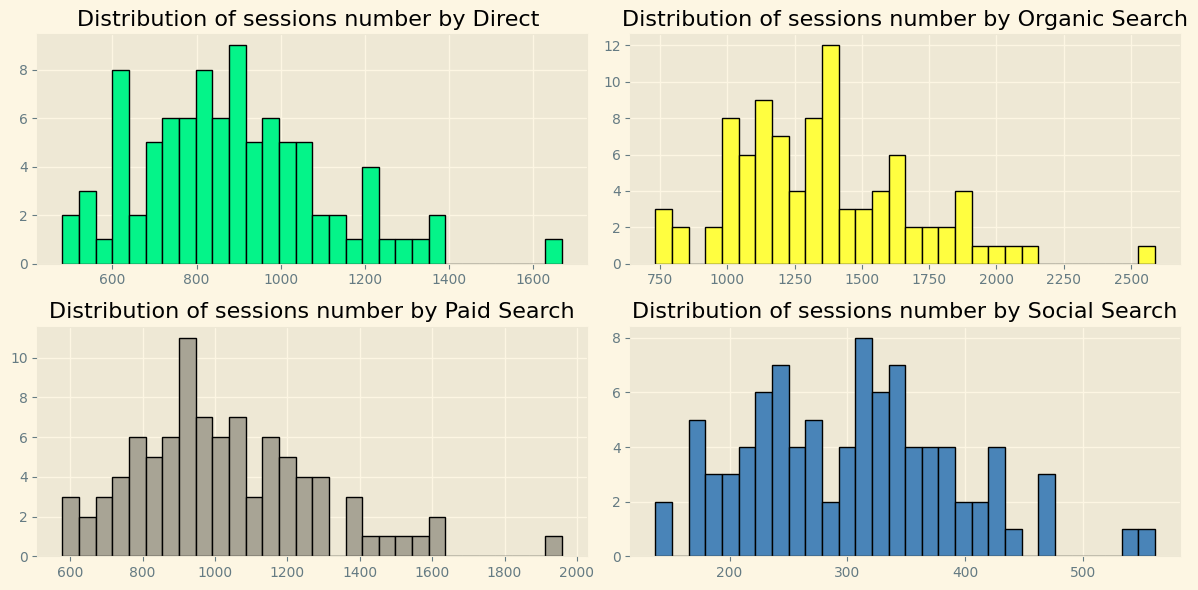

In [ ]:
# Normaltest
_, p_value_normaltest_Direct = stats.normaltest(sessions_by_channel['Direct'])
_, p_value_normaltest_organic = stats.normaltest(sessions_by_channel['Organic Search'])
_, p_value_normaltest_paid = stats.normaltest(sessions_by_channel['Paid Search'])
_, p_value_normaltest_social = stats.normaltest(sessions_by_channel['Social Search'])


# Test results
print(f"Normaltest for Direct p-value: {p_value_normaltest_Direct}")
print(f"Normaltest for Organic search p-value: {p_value_normaltest_organic}")
print(f"Normaltest for Paid Search p-value: {p_value_normaltest_paid}")
print(f"Normaltest for Social Search p-value: {p_value_normaltest_social}\n")


# Plotting histograms to visualize data distributions
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.hist(sessions_by_channel['Direct'], bins=30, color="#04f489", edgecolor="black")
plt.title("Distribution of sessions number by Direct ")

plt.subplot(2, 2, 2)
plt.hist(sessions_by_channel['Organic Search'], bins=30, color="#fffe40", edgecolor="black")
plt.title("Distribution of sessions number by Organic Search")

plt.subplot(2, 2, 3)
plt.hist(sessions_by_channel['Paid Search'], bins=30, color="#a8a495", edgecolor="black")
plt.title("Distribution of sessions number by Paid Search")

plt.subplot(2, 2, 4)
plt.hist(sessions_by_channel['Social Search'], bins=30, color="#4984b8", edgecolor="black")
plt.title("Distribution of sessions number by Social Search")




plt.tight_layout()
plt.show()

Among the samples of session counts by traffic channels, only the **Social Search** channel has a normal distribution (**p-value: 0.214**). All other channels have a **p-value less than 0.05**, so their distributions are not normal. In this case, we will also use the **Kruskal-Wallis test**.

---

Серед вибірок кількості сесій за каналами трафіку нормальний розподіл має лише канал **Social Search** (**p-value: 0.214**), всі інші мають значення **p-value менше за 0.05**, тому розподіл у них ненормальний. У цьому випадку ми також використаємо **тест Крускала-Уолліса**.

In [ ]:
_, p_value_kruskal_channels = stats.kruskal(sessions_by_channel['Direct'], sessions_by_channel['Organic Search'], sessions_by_channel['Paid Search'],sessions_by_channel['Social Search'])

direct_median = sessions_by_channel['Direct'].median()
organic_median = sessions_by_channel['Organic Search'].median()
paid_median = sessions_by_channel['Paid Search'].median()
social_median = sessions_by_channel['Social Search'].median()

print(f"Direct Median: {direct_median:.2f}")
print(f"Organic Search Median: {organic_median:.2f}")
print(f"Paid Search Median: {paid_median:.2f}")
print(f"Social Search Median: {social_median:.2f}\n")

print(f"Kruskal-Wallis test by channels p-value: {p_value_kruskal_channels}")

Direct Median: 869.50
Organic Search Median: 1329.00
Paid Search Median: 989.00
Social Search Median: 308.00

Kruskal-Wallis test by channels p-value: 3.5370311010399424e-56


The **p-value** obtained from the **Kruskal-Wallis test**, which is less than **0.05**, indicates that the differences in the number of sessions by traffic channel are **statistically significant**. Therefore, we can accept the alternative hypothesis that the traffic channels differ from each other in the number of sessions. By comparing the median session counts for these channels, we can conclude that they have the following distribution from most to least popular:

1.  **Organic Search**
2.  **Paid Search**
3.  **Direct**
4.  **Social Search**

---

Отриманий за допомогою **тесту Крускала-Уолліса p-value**, який менший за **0.05**, свідчить про те, що відмінності в кількості сесій по каналах трафіку є **статистично значущими**. Тому ми можемо прийняти альтернативну гіпотезу про те, що канали трафіку відрізняються між собою за кількістю сесій. Порівнявши медіанні значення кількості сесій по цих каналах, можна сказати, що вони мають такий розподіл від найбільш популярного до найменш популярного:

1.  **Organic Search**
2.  **Paid Search**
3.  **Direct**
4.  **Social Search**


# **Conclusions**

[Link to the Tableau Dashboard](https://public.tableau.com/views/E-COMMERCECOMPANY/E-COMMERCECOMPANY?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link)

---
[Посилання на дашборд в Tableau](https://public.tableau.com/views/E-COMMERCECOMPANY/E-COMMERCECOMPANY?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link)


## **Conclusions**

The analysis covered the period from **01.11.2020** to **31.01.2021**. During this period, there were **349,545 website sessions**, **33,538 orders**, and **27,945 accounts created**. Website visits came from **107 countries** across **5 continents**. A revenue of **31,971,731** was obtained during this period. The company offers **550 different types of goods** in **14 categories**.

The most expensive categories are **Sofas & armchairs** and **Beds** (median unit prices are 1176 and 1095, respectively), while the cheapest are **Bookcases & shelving units** and **Children's furniture** (median unit prices are 235 and 195, respectively). The most profitable categories turned out to be **Sofas & armchairs** (**8,388,254** profit), **Chairs** (**6,147,749** profit), and **Beds** (**4,919,725** profit). The same category distribution is observed in the top-selling country, the **United States**.

The continents with the highest sales revenue are **the Americas, Asia, and Europe**. The **United States** stands out significantly among all countries and on all continents, taking first place in sales with a substantial lead and a total sales amount of about **14 million**. In Asia, the highest profit came from **India**, and in Europe, from the **United Kingdom**. Other countries in the top 5 for sales are also **Canada** and **France**.

The highest number of sessions comes from **desktop** devices, followed by **mobile**, while **tablet** is the least popular. The distribution of traffic channels does not depend on the type of device and is the same for all: the most users come from **organic search**, followed by **paid search**, and the last place is taken by **social media**. The most popular browsers are **Chrome** and **Safari**, which together account for about **90%** of visits, indicating the need to primarily optimize the website for them.
The largest share of sales is accounted for by the following combinations of devices and their types: **`desktop + Chrome`** - **27.8%**; **`desktop + Safari`** - **20.3%**; **`mobile + iPhone`** - **20%** and **`mobile + Other Model Name`** - **17.9%**. By traffic channel, the most profitable is **Organic Search** - **35.8%** of profit, followed by **Paid Search** - **26.6%** and **Direct** - **23.4%**.

Among all sessions, only about **8%** of users registered their accounts. Of the registered users, **71.7%** confirmed their account, and **83.1%** subscribed to the newsletter. At the same time, the vast majority of purchases are made by **unregistered users**. For both registered and unregistered users, the dominance of the **organic traffic channel** is maintained. The distribution of traffic channels among user types is the same and corresponds to the overall trend.

The dynamics of expected and actual revenue mostly coincide, which indicates that the forecasts for revenue growth and decline on certain days are correct. However, the level of actual revenue is always less than forecasted. The most profitable days are **December 6, December 12, and January 6**. The least profitable days are **November 7, November 16, and January 10**. In general, revenue remains at a fairly stable level in the range of **200,000 to 600,000 per day**. Revenue throughout the week remains approximately stable. The highest revenue is observed on **Tuesday** and **Wednesday**, and the lowest on **Saturday** and **Sunday**.

The sales dynamics of registered and unregistered users approximately coincide on the days of rise and fall.

The sales dynamics by country show that **India, the United Kingdom, Canada, and France** have approximately the same level and a similar dynamic, with different fluctuations on certain days, but generally stable. The **USA** stands out with a significantly higher level of revenue in a constant dynamic. In the **USA**, the most profitable days were **January 6, December 8, and December 10**.

All traffic channels demonstrate a similar dynamic, with peaks and dips occurring in the same period, which indicates their stable operation. **Organic Search** maintains its dominant position throughout the period. **Social Search** is consistently the channel with the lowest revenue. **Direct** and **Paid Search** occupy an intermediate position, crossing and swapping places in terms of dominance and decline.

In the course of the statistical analysis, the following insights were obtained:
* There is a **direct linear relationship** between the number of sessions and the level of sales, which indicates that the more users the company attracts to the website, the more sales occur.
* There is a **direct linear relationship** between the level of forecasted revenue and actual sales, which suggests that revenue forecasting is done correctly.
* We obtained **statistical confirmation** that unregistered users buy more than registered users, with a statistically significant difference.
* Categories are statistically different from each other in terms of total sales and have the following distribution from most to least profitable:
    1. **Sofas & armchairs**
    2. **Chairs**
    3. **Beds**
    4. **Cabinets & cupboards**
    5. **Bookcases & shelving units**;
* Traffic channels also statistically differ from each other in the number of sessions and have the following distribution from most to least popular:
    1. **Organic Search**
    2. **Paid Search**
    3. **Direct**
    4. **Social Search**

### **Possible Recommendations for the Company's Activities:**

**Encouraging User Registration**. Since most purchases are made by unregistered users, it is worth focusing on their retention through registration, for example, by implementing a loyalty program.

**Supporting the Most Profitable Categories and Developing Others**. Given the high profitability of the `Sofas & armchairs`, `Chairs`, and `Beds` categories, it is necessary to increase marketing efforts specifically for these products. It may be worthwhile to expand the assortment in these categories and create separate advertising campaigns for their promotion. It is also worth paying attention to other, less profitable categories, and reconsidering their pricing and marketing strategies.

**Focus on Traffic Channels**. Since `Organic Search` and `Paid Search` are the main sources of traffic and revenue, it is important to continue the development of these channels to attract an ever-increasing number of users. **Social media search** brings almost no results; it might make sense to consider stopping the financing of this traffic channel to free up resources.

**Focus on Key Markets**. The USA is the sales leader, so additional resources should be allocated to this market by developing localized marketing strategies and offers that will meet the preferences of American consumers.

**Optimization for Device Types and Browsers**. Since most visitors use **Chrome** and **Safari** browsers, and also access the site from **desktop** and **mobile** devices, it is necessary to optimize the website for these browsers and devices.

**Continuing the Forecasting Strategy**. Revenue forecasting is correct and coincides with actual revenues on days of sales growth and decline. The existing forecasting strategy should be followed going forward.

## **Висновки**

Аналіз охопив період з **01.11.2020 р.** по **31.01.2021 р.** За цей період було **349 545 сесій** відвідування сайту, **33 538 замовлень**, створено **27 945 акаунтів**. Відвідування сайту відбувалися зі **107 країн** з **5 континентів**. За вказаний період отримано **31 971 731 доходу**. Компанія пропонує **550 різних видів товарів** у **14 категоріях**.

Найдорожчими категоріями є **Sofas & armchairs** та **Beds** (медіанна ціна одиниці товару 1176 та 1095 відповідно), а найдешевшими - **Bookcases & shelving units** та **Children's furniture** (медіанна ціна одиниці товару 235 та 195 відповідно). При цьому найбільш прибутковими категоріями виявилися **Sofas & armchairs** (**8 388 254** прибутку), **Chairs** (**6 147 749** прибутку) та **Beds** (**4 919 725** прибутку). Такий самий розподіл категорій спостерігається і в топовій країні за продажами - **Сполучених Штатах**.

Найбільш великими за сумою продажів континентами є **Америка, Азія та Європа**. При цьому **Сполучені Штати** дуже сильно виділяються серед усіх країн як на своєму, так і на всіх інших континентах, займаючи перше місце в продажах зі значним відривом та загальною сумою продажів близько **14 млн**. В Азії найбільший прибуток був з **Індії**, у Європі - зі **Сполученого Королівства**. Крім цих країн, до топ-5 за продажами входять також **Канада** та **Франція**.

Найбільша кількість сесій відбувається з приладів типу **desktop**, друге місце посідає **mobile**, а найменш популярним є **tablet**. Розподіл каналів трафіку не залежить від типу приладів і є однаковим для всіх: найбільше користувачів приходить з **органічного пошуку**, на другому місці **платний пошук**, а останнє місце посідають **соціальні мережі**. Найбільш популярними браузерами є **Chrome** та **Safari**, які разом займають близько **90%** відвідувань, що свідчить про необхідність оптимізації сайту в першу чергу саме під них.
Найбільшу частку продажів займають такі комбінації девайсів та їх типів: **`desktop + Chrome`** - **27.8%**; **`desktop + Safari`** - **20.3%**; **`mobile + iPhone`** - **20%** та **`mobile + Other Model Name`** - **17.9%**. По каналах трафіку найбільш прибутковим є **Organic Search** - **35.8%** прибутку, далі ідуть **Paid Search** - **26.6%** та **Direct** - **23.4%**.

Серед усіх сесій всього близько **8%** користувачів зареєстрували свій акаунт. Із зареєстрованих користувачів **71.7%** підтвердили свій акаунт, і **83.1%** підписалися на розсилку. При цьому переважна більшість покупок відбувається **незареєстрованими користувачами**. Як для зареєстрованих, так і для незареєстрованих користувачів зберігається домінування **органічного каналу трафіку**. Розподіл каналів трафіку між типами користувачів однаковий і відповідає загальній тенденції.

Динаміка очікуваного та реального доходу переважно збігається, що свідчить про те, що прогнози щодо зростання та спадів доходу в певні дні є вірними. Однак, рівень реального доходу завжди менший за прогнозований. Найбільш прибуткові дні - це **6 грудня, 12 грудня та 6 січня**. Найменш прибуткові дні - **7 листопада, 16 листопада та 10 січня**. Загалом, дохід тримається на доволі стабільному рівні в діапазоні від **200 000 до 600 000** за день.
Дохід протягом тижня залишається приблизно стабільним. Найбільший дохід спостерігається у **вівторок** та **середу**, найменший - у **суботу** та **неділю**.

Динаміка продажів зареєстрованих та незареєстрованих користувачів приблизно збігається по днях підйому та спадання.

Динаміка продажів по країнах показує, що **Індія, Сполучене Королівство, Канада та Франція** мають приблизно однаковий рівень і схожу динаміку, з різними коливаннями в окремі дні, але в цілому стабільними. **США** значно виділяються більшим рівнем доходу у постійній динаміці. У **США** найбільш прибутковими днями були **6 січня, 8 та 10 грудня**.

Усі канали трафіку демонструють схожу динаміку, з піками та спадами, що відбуваються в один і той же період, що свідчить про їх стабільну роботу. **Organic Search** зберігає домінуючу позицію протягом усього часу. **Social Search** постійно є каналом з найменшим доходом. **Direct** та **Paid Search** займають проміжне положення, перетинаючись та міняючись місцями за домінуванням і спадом.

В ході проведення статистичного аналізу було отримано наступні інсайти:
* існує **пряма лінійна залежність** між кількістю сесій та рівнем продажів, що говорить про те, що чим більше користувачів компанія приваблює на сайт, тим більше продажів відбувається;
* існує **пряма лінійна залежність** між рівнем прогнозованого доходу та реальними продажами, що свідчить про те, що прогнозування доходів відбувається правильно;
* ми отримали **статистичне підтвердження** того, що незареєстровані користувачі купують більше, ніж зареєстровані, зі статистично значущою різницею;
* категорії статистично відрізняються між собою за сумою продажів і мають такий розподіл від найбільш прибуткової за зниженням прибутку:
    1. **Sofas & armchairs**
    2. **Chairs**
    3. **Beds**
    4. **Cabinets & cupboards**
    5. **Bookcases & shelving units**;
* канали трафіку також статистично відрізняються між собою за кількістю сесій і мають такий розподіл від найбільш популярного до найменш популярного:
    1. **Organic Search**
    2. **Paid Search**
    3. **Direct**
    4. **Social Search**

**Можливі рекомендації щодо діяльності компанії:**

**Стимулювання реєстрції користувачів**. Оскільки більшість покупок відбувається незареєстрованими користувачами, варто зосередитися на їх утриманні за допомогою реєстрації, наприклад за допомогою впровадження програми лояльності.

**Підтримка найприбутковіших категорій та розвиток інших**. З огляду на високу прибутковість категорій `Sofas & armchairs`, `Chairs` та `Beds`, необхідно збільшити маркетингові зусилля саме на ці товари. Можливо, варто розширити асортимент у цих категоріях та створити окремі рекламні кампанії для їх просування. Також варто звернути увагу на інші, менш прибуткові категорії, переглнути цінову політику по ним та маркетингову стратегію.

**Акцент на каналах трафіку**. Оскільки `Organic Search` та `Paid Search` є основними джерелами трафіку та прибутку, важливо продовжувати розвиток саме цих каналів для приваблення все більшої кількосіт користувачів. **Пошук через соціальні мережі** майде не приносить резлуьтатів, можливо є сенс розглянути можливість припинення фінансування цього каналу трафіку для вивільнення ресурсів.

**Фокус на ключових ринках**: США є лідером за продажами, тому слід виділити додаткові ресурси на цей ринок, розробивши локалізовних маркетингових стратегій та пропозицій, що відповідатимуть уподобанням американських споживачів.

**Оптимізація під типи пристроїв та браузерів**. Оскільки більшість відвідувачів користуються браузерами **Chrome та Safari**, а також заходять на сайт з **настільних та мобільних пристроїв**, необхідно провести оптимизіцаю сайту під ці бразуери та пристрої.

**Прожовження статегії щодо прогнозування**. Прогнозування доходів відбувається коректно і збігається з реальними доходами по дням зростання та спадання продажів. Слід і надалі дотримуватися наявній стратегії прогнозування.



In [ ]:
# company_data.to_csv('сompany_data.csv', index=False)